In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import math
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import random

torch.set_default_dtype(torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

## Dataset

In [326]:
def get_permuted_mnist(n_tasks=3, batch_size=256, root='./data'):
    input_size = 784
    permutations = [np.random.permutation(input_size) for _ in range(n_tasks)]
    
    tasks = []
    
    for cur_task in range(n_tasks):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x, p=permutations[cur_task]: x.reshape(-1)[p])
        ])
        
        train_dataset = datasets.MNIST(root, train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root, train=False, download=True, transform=transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        tasks.append((train_loader, test_loader))
    
    return tasks

In [327]:
def get_split_mnist(batch_size=256, root='./data'):  
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.reshape(-1))])
    train_dataset = datasets.MNIST(root, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root, train=False, download=True, transform=transform)
    
    train_targets = train_dataset.targets
    test_targets = test_dataset.targets
        
    tasks = []
    
    for task_ind in range(5):
        start_digit = task_ind * 2
        end_digit = (task_ind + 1) * 2
        task_digits = list(range(start_digit, end_digit))
        
        train_mask = torch.zeros_like(train_targets, dtype=torch.bool)
        test_mask = torch.zeros_like(test_targets, dtype=torch.bool)
        
        for digit in task_digits:
            train_mask = train_mask | (train_targets == digit)
            test_mask = test_mask | (test_targets == digit)
        
        train_indices = torch.nonzero(train_mask, as_tuple=True)[0]
        test_indices = torch.nonzero(test_mask, as_tuple=True)[0]
        
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        test_subset = torch.utils.data.Subset(test_dataset, test_indices)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
        
        tasks.append((train_loader, test_loader))
    
    return tasks

## Simple MLP

In [328]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=100, output_dim=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Permuted

In [329]:
def train_simple(tasks, epochs=5, lr=1e-3):
    model = SimpleMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    results = []
    
    for task_ind, (train_loader, test_loader) in enumerate(tasks):
        print(f"\nTraining on task {task_ind}...")
        for ep in range(epochs):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(x)
                loss = loss_fn(logits, y)
                loss.backward()
                optimizer.step()
        
        task_accuracies = []
        for eval_ind, (_, eval_test_loader) in enumerate(tasks[:task_ind+1]):
            correct, total = 0, 0
            model.eval()
            with torch.no_grad():
                for x, y in eval_test_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    preds = logits.argmax(dim=1)
                    correct += (preds == y).sum().item()
                    total += y.size(0)
            acc = 100.0 * correct / total   
            task_accuracies.append(acc)
        mean_acc = np.mean(task_accuracies)
        results.append((task_ind, mean_acc))
        print(f"Task {task_ind} - Mean Acc so far: {mean_acc:.2f}")
    
    return model, results


# tasks_small_test = get_permuted_mnist(n_tasks=2, batch_size=256)
# model_small_test, results_small_test = train_simple(tasks_small_test, epochs=2, lr=1e-3)
# print("Naive finetune results:", results_small_test)

In [10]:
def train_pretrained_model(train_loader, epochs=5, lr=1e-3):
    model = SimpleMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if ep % 2 == 0 or ep == epochs-1:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    preds = logits.argmax(dim=1)
                    correct += (preds == y).sum().item()
                    total += y.size(0)
            acc = 100.0 * correct / total
            print(f"Epoch {ep+1}/{epochs}: Loss={epoch_loss/len(train_loader):.4f}, Accuracy={acc:.2f}%")
    
    return model

### Split

In [330]:
def train_simple_splitmnist(tasks, epochs=5, lr=1e-3):
    model = SimpleMLP(hidden_dim=256, output_dim=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    results = []
    
    for task_ind, (train_loader, test_loader) in enumerate(tasks):
        print(f"\nTraining on split MNIST task {task_ind}...")
        for ep in range(epochs):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                y = y % 2 
                
                optimizer.zero_grad()
                logits = model(x)
                loss = loss_fn(logits, y)
                loss.backward()
                optimizer.step()
        
        task_accuracies = []
        for eval_ind, (_, eval_test_loader) in enumerate(tasks[:task_ind+1]):
            correct, total = 0, 0
            model.eval()
            with torch.no_grad():
                for x, y in eval_test_loader:
                    x, y = x.to(device), y.to(device)
                    y = y % 2 
                    
                    logits = model(x)
                    preds = logits.argmax(dim=1)
                    correct += (preds == y).sum().item()
                    total += y.size(0)
            acc = 100.0 * correct / total   
            task_accuracies.append(acc)
        mean_acc = np.mean(task_accuracies)
        results.append((task_ind, mean_acc))
        print(f"Task {task_ind} - Mean Acc so far: {mean_acc:.2f}")
    
    return model, results

## EWC

In [331]:
class EWC():
    def __init__(self, model, fisher_sample_size=600, lambda_=1):
        self.model = model
        self.fisher_sample_size = fisher_sample_size
        self.lambda_ = lambda_
        
        self.params = {n: p.clone().detach() for n, p in model.named_parameters()}
        self.fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
        
        self.fisher_tasks = {}
        self.param_tasks = {}
        
    def compute_fisher(self, data_loader):
        self.model.eval()
        fisher = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        
        loss_fn = nn.CrossEntropyLoss()
        samples_seen = 0
        
        for x, y in data_loader:
            if samples_seen >= self.fisher_sample_size:
                break
                
            x, y = x.to(device), y.to(device)
            
            if hasattr(data_loader.dataset, 'dataset') and len(data_loader.dataset) > 0:
                if hasattr(data_loader.dataset, 'indices') and y.max() > 1:
                    y = y % 2
            
            current_batch_size = min(x.size(0), self.fisher_sample_size - samples_seen)
            if current_batch_size <= 0:
                break
                
            x = x[:current_batch_size]
            y = y[:current_batch_size]
            
            for i in range(current_batch_size):
                self.model.zero_grad()
                outputs = self.model(x[i:i+1])
                loss = loss_fn(outputs, y[i:i+1])
                loss.backward()
                
                for n, p in self.model.named_parameters():
                    if p.grad is not None:
                        fisher[n] += p.grad**2 / self.fisher_sample_size
            
                samples_seen += 1
        
        return fisher
    
    def consolidate_task(self, task_id, data_loader):
        self.param_tasks[task_id] = {n: p.clone().detach() for n, p in self.model.named_parameters()}
        self.fisher_tasks[task_id] = self.compute_fisher(data_loader)
        self.params = {n: p.clone().detach() for n, p in self.model.named_parameters()}
        
        self.fisher = {}
        num_tasks = len(self.fisher_tasks)
        for n, _ in self.model.named_parameters():
            self.fisher[n] = torch.zeros_like(self.params[n])
            for tid in self.fisher_tasks:
                self.fisher[n] += self.fisher_tasks[tid][n] / num_tasks
    
    def ewc_loss(self):
        loss = 0
        for n, p in self.model.named_parameters():
            loss += (self.fisher[n] * (p - self.params[n])**2).sum()
        return 0.5 * self.lambda_ * loss

### Permuted

In [332]:
def train_ewc(model, ewc, train_loader, optimizer, epochs=3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            
            outputs = model(x)
            task_loss = criterion(outputs, y)
            ewc_reg_loss = ewc.ewc_loss()
            loss = task_loss + ewc_reg_loss
            
            loss.backward()
            optimizer.step()
            
def run_ewc_permuted_mnist(tasks, epochs=3, lambda_=1):
    model = SimpleMLP().to(device)
    ewc = EWC(model, fisher_sample_size=600, lambda_=lambda_)
    
    results = []
    
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        print(f"Training on Task {t_idx} with EWC...")
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        train_ewc(model, ewc, train_loader, optimizer, epochs=epochs)
        ewc.consolidate_task(t_idx, train_loader)
        
        task_accuracies = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            correct, total = 0, 0
            model.eval()
            with torch.no_grad():
                for x, y in test_loader_eval:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    pred = outputs.argmax(dim=1)
                    correct += (pred == y).sum().item()
                    total += y.size(0)
            acc = 100.0 * correct / total
            task_accuracies.append(acc)
        
        mean_acc = np.mean(task_accuracies)
        results.append((t_idx, mean_acc))
        print(f"Task {t_idx} - Accuracies: {task_accuracies}")
        print(f"Task {t_idx} - Mean Acc so far: {mean_acc:.2f}")
    
    return model, results

In [257]:
# tasks_small_test = get_permuted_mnist(n_tasks=5, batch_size=256)
# model_ewc, results_ewc = run_ewc_permuted_mnist(tasks_small_test, epochs=10)
# print("Final Results:", results_ewc)

### Split

In [333]:
def train_ewc_splitmnist(model, ewc, train_loader, optimizer, epochs=3):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            y = y % 2
            
            optimizer.zero_grad()
    
            outputs = model(x)
            task_loss = loss_fn(outputs, y)
            ewc_reg_loss = ewc.ewc_loss()
            loss = task_loss + ewc_reg_loss
            
            loss.backward()
            optimizer.step()

def run_ewc_split_mnist(tasks, epochs=3, lambda_=1):
    model = SimpleMLP(output_dim=2).to(device)
    ewc = EWC(model, fisher_sample_size=600, lambda_=lambda_)
    
    results = []
    
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        print(f"Training on Split MNIST Task {t_idx} with EWC...")
        
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
        train_ewc_splitmnist(model, ewc, train_loader, optimizer, epochs=epochs)
        
        ewc.consolidate_task(t_idx, train_loader)
        
        task_accuracies = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            correct, total = 0, 0
            model.eval()
            with torch.no_grad():
                for x, y in test_loader_eval:
                    x, y = x.to(device), y.to(device)
                    y = y % 2
                    
                    outputs = model(x)
                    pred = outputs.argmax(dim=1)
                    correct += (pred == y).sum().item()
                    total += y.size(0)
            acc = 100.0 * correct / total
            task_accuracies.append(acc)
        
        mean_acc = np.mean(task_accuracies)
        results.append((t_idx, mean_acc))
        print(f"Task {t_idx} - Accuracies: {task_accuracies}")
        print(f"Task {t_idx} - Mean Acc so far: {mean_acc:.2f}")
    
    return model, results

## VCL

In [334]:
class VCL_NN(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=100, output_dim=10, init_std=1e-2, 
                 num_heads=1, init_from_pretrained=False, pretrained_model=None):
        super(VCL_NN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.outputs_per_head = output_dim if num_heads == 1 else 2
        self.init_from_pretrained = init_from_pretrained
        self.pretrained_model = pretrained_model
        
        init_rho = torch.log(torch.exp(torch.tensor(init_std)) - 1.0)
        self.fc1_weight_mu = nn.Parameter(torch.zeros(hidden_dim, input_dim))
        self.fc1_weight_rho = nn.Parameter(
            torch.ones(hidden_dim, input_dim) * init_rho
        )
        self.fc1_bias_mu = nn.Parameter(torch.zeros(hidden_dim))
        self.fc1_bias_rho = nn.Parameter(
            torch.ones(hidden_dim) * init_rho
        )
        
        self.fc2_weight_mu = nn.Parameter(torch.zeros(hidden_dim, hidden_dim))
        self.fc2_weight_rho = nn.Parameter(
            torch.ones(hidden_dim, hidden_dim) * init_rho
        )
        self.fc2_bias_mu = nn.Parameter(torch.zeros(hidden_dim))
        self.fc2_bias_rho = nn.Parameter(
            torch.ones(hidden_dim) * init_rho
        )
        
        self.fc3_weight_mu = nn.ParameterList([
            nn.Parameter(torch.zeros(self.outputs_per_head, hidden_dim)) 
            for _ in range(num_heads)
        ])
        self.fc3_weight_rho = nn.ParameterList([
            nn.Parameter(torch.ones(self.outputs_per_head, hidden_dim) * init_rho)
            for _ in range(num_heads)
        ])
        self.fc3_bias_mu = nn.ParameterList([
            nn.Parameter(torch.zeros(self.outputs_per_head))
            for _ in range(num_heads)
        ])
        self.fc3_bias_rho = nn.ParameterList([
            nn.Parameter(torch.ones(self.outputs_per_head) * init_rho)
            for _ in range(num_heads)
        ])
        
        self.prev_fc1_weight_mu = None
        self.prev_fc1_weight_sigma = None
        self.prev_fc1_bias_mu = None
        self.prev_fc1_bias_sigma = None
        
        self.prev_fc2_weight_mu = None
        self.prev_fc2_weight_sigma = None
        self.prev_fc2_bias_mu = None
        self.prev_fc2_bias_sigma = None
        
        self.prev_fc3_weight_mu = [None] * num_heads
        self.prev_fc3_weight_sigma = [None] * num_heads
        self.prev_fc3_bias_mu = [None] * num_heads
        self.prev_fc3_bias_sigma = [None] * num_heads
        
        self.active_heads = set()
        
        self.to(device)
        self._init_params()
    
    def _init_params(self):
        if not self.init_from_pretrained or self.pretrained_model is None:
            nn.init.xavier_normal_(self.fc1_weight_mu)
            nn.init.xavier_normal_(self.fc2_weight_mu)
            nn.init.zeros_(self.fc1_bias_mu)
            nn.init.zeros_(self.fc2_bias_mu)
            
            for h in range(self.num_heads):
                nn.init.xavier_normal_(self.fc3_weight_mu[h])
                nn.init.zeros_(self.fc3_bias_mu[h])
        else:
            self._load_from_pretrained()
    
    def _load_from_pretrained(self):
        if isinstance(self.pretrained_model, SimpleMLP):
            self.fc1_weight_mu.data.copy_(self.pretrained_model.fc1.weight.data)
            self.fc1_bias_mu.data.copy_(self.pretrained_model.fc1.bias.data)
            self.fc2_weight_mu.data.copy_(self.pretrained_model.fc2.weight.data)
            self.fc2_bias_mu.data.copy_(self.pretrained_model.fc2.bias.data)
            
            if self.num_heads == 1:
                self.fc3_weight_mu[0].data.copy_(self.pretrained_model.fc3.weight.data)
                self.fc3_bias_mu[0].data.copy_(self.pretrained_model.fc3.bias.data)
            else:
                for h in range(self.num_heads):
                    nn.init.xavier_normal_(self.fc3_weight_mu[h])
                    nn.init.zeros_(self.fc3_bias_mu[h])
    
    def sample_params(self, head_ind=None):
        fc1_weight_sigma = torch.log1p(torch.exp(self.fc1_weight_rho))
        fc1_bias_sigma = torch.log1p(torch.exp(self.fc1_bias_rho))
        fc2_weight_sigma = torch.log1p(torch.exp(self.fc2_weight_rho))
        fc2_bias_sigma = torch.log1p(torch.exp(self.fc2_bias_rho))
        
        w1 = self.fc1_weight_mu + torch.randn_like(fc1_weight_sigma).to(device) * fc1_weight_sigma
        b1 = self.fc1_bias_mu + torch.randn_like(fc1_bias_sigma).to(device) * fc1_bias_sigma
        w2 = self.fc2_weight_mu + torch.randn_like(fc2_weight_sigma).to(device) * fc2_weight_sigma
        b2 = self.fc2_bias_mu + torch.randn_like(fc2_bias_sigma).to(device) * fc2_bias_sigma
        
        if head_ind is not None:
            fc3_weight_sigma = torch.log1p(torch.exp(self.fc3_weight_rho[head_ind]))
            fc3_bias_sigma = torch.log1p(torch.exp(self.fc3_bias_rho[head_ind]))
            w3 = self.fc3_weight_mu[head_ind] + torch.randn_like(fc3_weight_sigma).to(device) * fc3_weight_sigma
            b3 = self.fc3_bias_mu[head_ind] + torch.randn_like(fc3_bias_sigma).to(device) * fc3_bias_sigma
            
            return (w1, b1, w2, b2, w3, b3, head_ind)
        else:
            if self.num_heads == 1:
                fc3_weight_sigma = torch.log1p(torch.exp(self.fc3_weight_rho[0]))
                w3 = self.fc3_weight_mu[0] + torch.randn_like(fc3_weight_sigma).to(device) * fc3_weight_sigma
                
                fc3_bias_sigma = torch.log1p(torch.exp(self.fc3_bias_rho[0]))
                b3 = self.fc3_bias_mu[0] + torch.randn_like(fc3_bias_sigma).to(device) * fc3_bias_sigma
                
                return (w1, b1, w2, b2, w3, b3)
            else:
                w3_list = []
                b3_list = []
                for h in range(self.num_heads):
                    fc3_weight_sigma = torch.log1p(torch.exp(self.fc3_weight_rho[h]))
                    w3 = self.fc3_weight_mu[h] + torch.randn_like(fc3_weight_sigma).to(device) * fc3_weight_sigma
                    
                    fc3_bias_sigma = torch.log1p(torch.exp(self.fc3_bias_rho[h]))
                    b3 = self.fc3_bias_mu[h] + torch.randn_like(fc3_bias_sigma).to(device) * fc3_bias_sigma
                    
                    w3_list.append(w3)
                    b3_list.append(b3)
                
                return (w1, b1, w2, b2, w3_list, b3_list, None)
    
    def forward(self, x, sampled_params):
        w1, b1, w2, b2 = sampled_params[:4]
        
        h1 = F.relu(torch.matmul(x, w1.t()) + b1)
        h2 = F.relu(torch.matmul(h1, w2.t()) + b2)
        
        if self.num_heads == 1 and len(sampled_params) == 6:
            w3, b3 = sampled_params[4], sampled_params[5]
            out = torch.matmul(h2, w3.t()) + b3
            return out
        
        if len(sampled_params) == 7 and sampled_params[6] is not None:
            w3, b3 = sampled_params[4], sampled_params[5]
            head_idx = sampled_params[6]
            out = torch.matmul(h2, w3.t()) + b3
            return out
        else:
            w3_list, b3_list = sampled_params[4], sampled_params[5]
            outputs = []
            for h in range(self.num_heads):
                out_h = torch.matmul(h2, w3_list[h].t()) + b3_list[h]
                outputs.append(out_h)
            return outputs
    
    def prior_kl(self, head_idx=None):
        def kl_gaussian(mu_q, sigma_q, mu_p, sigma_p):
            return torch.log(sigma_p / sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2)/(2*sigma_p**2) - 0.5
        
        kl = 0.0
        
        sigma_q_fc1_w = torch.log1p(torch.exp(self.fc1_weight_rho))
        sigma_q_fc1_b = torch.log1p(torch.exp(self.fc1_bias_rho))
        sigma_q_fc2_w = torch.log1p(torch.exp(self.fc2_weight_rho))
        sigma_q_fc2_b = torch.log1p(torch.exp(self.fc2_bias_rho))
        
        if self.prev_fc1_weight_mu is not None:
            kl += kl_gaussian(self.fc1_weight_mu, sigma_q_fc1_w, 
                             self.prev_fc1_weight_mu, self.prev_fc1_weight_sigma).sum()
            kl += kl_gaussian(self.fc1_bias_mu, sigma_q_fc1_b,
                             self.prev_fc1_bias_mu, self.prev_fc1_bias_sigma).sum()
            kl += kl_gaussian(self.fc2_weight_mu, sigma_q_fc2_w,
                             self.prev_fc2_weight_mu, self.prev_fc2_weight_sigma).sum()
            kl += kl_gaussian(self.fc2_bias_mu, sigma_q_fc2_b,
                             self.prev_fc2_bias_mu, self.prev_fc2_bias_sigma).sum()
        
        if head_idx is not None:
            if self.prev_fc3_weight_mu[head_idx] is not None:
                sigma_q = torch.log1p(torch.exp(self.fc3_weight_rho[head_idx]))
                mu_q = self.fc3_weight_mu[head_idx]
                mu_p = self.prev_fc3_weight_mu[head_idx]
                sigma_p = self.prev_fc3_weight_sigma[head_idx]
                kl += kl_gaussian(mu_q, sigma_q, mu_p, sigma_p).sum()
                
                sigma_q = torch.log1p(torch.exp(self.fc3_bias_rho[head_idx]))
                mu_q = self.fc3_bias_mu[head_idx]
                mu_p = self.prev_fc3_bias_mu[head_idx]
                sigma_p = self.prev_fc3_bias_sigma[head_idx]
                kl += kl_gaussian(mu_q, sigma_q, mu_p, sigma_p).sum()
        else:
            if self.num_heads == 1:
                if self.prev_fc3_weight_mu[0] is not None:
                    sigma_q = torch.log1p(torch.exp(self.fc3_weight_rho[0]))
                    mu_q = self.fc3_weight_mu[0]
                    mu_p = self.prev_fc3_weight_mu[0]
                    sigma_p = self.prev_fc3_weight_sigma[0]
                    kl += kl_gaussian(mu_q, sigma_q, mu_p, sigma_p).sum()
                    
                    sigma_q = torch.log1p(torch.exp(self.fc3_bias_rho[0]))
                    mu_q = self.fc3_bias_mu[0]
                    mu_p = self.prev_fc3_bias_mu[0]
                    sigma_p = self.prev_fc3_bias_sigma[0]
                    kl += kl_gaussian(mu_q, sigma_q, mu_p, sigma_p).sum()
            else:
                for h in self.active_heads:
                    if self.prev_fc3_weight_mu[h] is not None:
                        sigma_q = torch.log1p(torch.exp(self.fc3_weight_rho[h]))
                        mu_q = self.fc3_weight_mu[h]
                        mu_p = self.prev_fc3_weight_mu[h]
                        sigma_p = self.prev_fc3_weight_sigma[h]
                        kl += kl_gaussian(mu_q, sigma_q, mu_p, sigma_p).sum()
                        
                        sigma_q = torch.log1p(torch.exp(self.fc3_bias_rho[h]))
                        mu_q = self.fc3_bias_mu[h]
                        mu_p = self.prev_fc3_bias_mu[h]
                        sigma_p = self.prev_fc3_bias_sigma[h]
                        kl += kl_gaussian(mu_q, sigma_q, mu_p, sigma_p).sum()
        
        return kl
    
    def consolidate_posteriors(self, head_idx=None):
        sigma_fc1_w = torch.log1p(torch.exp(self.fc1_weight_rho)).detach()
        sigma_fc1_b = torch.log1p(torch.exp(self.fc1_bias_rho)).detach()
        sigma_fc2_w = torch.log1p(torch.exp(self.fc2_weight_rho)).detach()
        sigma_fc2_b = torch.log1p(torch.exp(self.fc2_bias_rho)).detach()
        
        self.prev_fc1_weight_mu = self.fc1_weight_mu.detach()
        self.prev_fc1_weight_sigma = sigma_fc1_w
        
        self.prev_fc1_bias_mu = self.fc1_bias_mu.detach()
        self.prev_fc1_bias_sigma = sigma_fc1_b
        
        self.prev_fc2_weight_mu = self.fc2_weight_mu.detach()
        self.prev_fc2_weight_sigma = sigma_fc2_w
        
        self.prev_fc2_bias_mu = self.fc2_bias_mu.detach()
        self.prev_fc2_bias_sigma = sigma_fc2_b
        
        if head_idx is not None:
            sigma_fc3_w = torch.log1p(torch.exp(self.fc3_weight_rho[head_idx])).detach()
            sigma_fc3_b = torch.log1p(torch.exp(self.fc3_bias_rho[head_idx])).detach()
            
            self.prev_fc3_weight_mu[head_idx] = self.fc3_weight_mu[head_idx].detach()
            self.prev_fc3_weight_sigma[head_idx] = sigma_fc3_w
            
            self.prev_fc3_bias_mu[head_idx] = self.fc3_bias_mu[head_idx].detach()
            self.prev_fc3_bias_sigma[head_idx] = sigma_fc3_b
            
            self.active_heads.add(head_idx)
        else:
            if self.num_heads == 1:
                sigma_fc3_w = torch.log1p(torch.exp(self.fc3_weight_rho[0])).detach()
                sigma_fc3_b = torch.log1p(torch.exp(self.fc3_bias_rho[0])).detach()
                
                self.prev_fc3_weight_mu[0] = self.fc3_weight_mu[0].detach()
                self.prev_fc3_weight_sigma[0] = sigma_fc3_w
                
                self.prev_fc3_bias_mu[0] = self.fc3_bias_mu[0].detach()
                self.prev_fc3_bias_sigma[0] = sigma_fc3_b
                
                self.active_heads.add(0)
            else:
                for h in range(self.num_heads):
                    sigma_fc3_w = torch.log1p(torch.exp(self.fc3_weight_rho[h])).detach()
                    sigma_fc3_b = torch.log1p(torch.exp(self.fc3_bias_rho[h])).detach()
                    
                    self.prev_fc3_weight_mu[h] = self.fc3_weight_mu[h].detach()
                    self.prev_fc3_weight_sigma[h] = sigma_fc3_w
                    
                    self.prev_fc3_bias_mu[h] = self.fc3_bias_mu[h].detach()
                    self.prev_fc3_bias_sigma[h] = sigma_fc3_b
                    
                    self.active_heads.add(h)

### Permuted

In [ ]:
def train_vcl_classification(model, train_loader, samples=1, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        batch_size = x.size(0)
        x_expanded = x.unsqueeze(0).expand(samples, batch_size, -1)
        y_expanded = y.unsqueeze(0).expand(samples, batch_size)
        
        sampled_params_list = [model.sample_params() for _ in range(samples)]
        
        total_loss = 0.0
        for i, sampled_params in enumerate(sampled_params_list):
            logits = model(x, sampled_params)
            total_loss += loss_fn(logits, y)
        loss = total_loss / samples
        
        kl = model.prior_kl()
        loss = loss + kl / len(train_loader.dataset)
        
        loss.backward()
        optimizer.step()

def evaluate_vcl_classification(model, test_loader, samples=5):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            batch_size = x.size(0)
            
            all_probs = torch.zeros(samples, batch_size, model.output_dim, device=device)            
            for s in range(samples):
                sampled_params = model.sample_params()
                logits = model(x, sampled_params)
                all_probs[s] = F.softmax(logits, dim=1)
            
            avg_probs = torch.mean(all_probs, dim=0)
            pred_labels = torch.argmax(avg_probs, dim=1)
            correct += (pred_labels == y).sum().item()
            total += batch_size
    
    return 100.0 * correct / total

def run_vcl_permuted_mnist(tasks, epochs=3, init_std=1e-2, pretrain=False):
    if pretrain:
        first_train_loader, _ = tasks[0]
        pretrained_model = train_pretrained_model(first_train_loader, epochs=5)
        model = VCL_NN(init_std=init_std, init_from_pretrained=True, pretrained_model=pretrained_model).to(device)
    else:
        model = VCL_NN(init_std=init_std).to(device)
    results = []
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        print(f"Training on Task {t_idx}")
        for ep in range(epochs):
            train_vcl_classification(model, train_loader, samples=1, lr=1e-3)
        model.consolidate_posteriors()
        
        all_acc = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            acc = evaluate_vcl_classification(model, test_loader_eval, samples=5)
            all_acc.append(acc)
        mean_acc = np.mean(all_acc)
        print(all_acc)
        print(f"Task {t_idx} - Average Acc so far: {mean_acc:.2f}")
        results.append(mean_acc)
    return model, results

In [209]:
tasks_small_test = get_permuted_mnist(n_tasks=5, batch_size=256)
model_vcl, results_vcl = run_vcl_permuted_mnist(tasks_small_test, init_std=9e-3, epochs=2, pretrain=True)
print("Final Results:", results_vcl)

Epoch 1/5: Loss=0.5476, Accuracy=92.66%
Epoch 3/5: Loss=0.1617, Accuracy=96.05%
Epoch 5/5: Loss=0.1057, Accuracy=97.35%
Training on Task 0
[96.77]
Task 0 - Average Acc so far: 96.77
Training on Task 1
[89.79, 79.1]
Task 1 - Average Acc so far: 84.44
Training on Task 2
[83.73, 76.21, 80.5]
Task 2 - Average Acc so far: 80.15
Training on Task 3
[83.32, 72.4, 72.01, 81.61]
Task 3 - Average Acc so far: 77.34
Training on Task 4
[76.71, 66.98, 72.84, 75.19, 82.41]
Task 4 - Average Acc so far: 74.83
Final Results: [np.float64(96.77), np.float64(84.445), np.float64(80.14666666666666), np.float64(77.33500000000001), np.float64(74.826)]


In [33]:
model_vcl, results_vcl = run_vcl_permuted_mnist(tasks_small_test, init_std=1e-1, epochs=10, pretrain=False)
print("Final Results:", results_vcl)

Training on Task 0
[96.89]
Task 0 - Average Acc so far: 96.89
Training on Task 1
[96.05, 95.09]
Task 1 - Average Acc so far: 95.57
Training on Task 2
[92.49, 93.8, 95.63]
Task 2 - Average Acc so far: 93.97
Training on Task 3
[88.01, 91.53, 92.3, 95.57]
Task 3 - Average Acc so far: 91.85
Training on Task 4
[76.83, 85.73, 86.64, 93.96, 95.63]
Task 4 - Average Acc so far: 87.76
Final Results: [np.float64(96.89), np.float64(95.57), np.float64(93.97333333333331), np.float64(91.8525), np.float64(87.758)]


### Split

In [ ]:
def train_vcl_classification_splitmnist(model, train_loader, head_idx, samples=1, lr=1e-3):
    """Train VCL on a specific split MNIST task using the corresponding head."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        y = y % 2 
        
        optimizer.zero_grad()
        
        loss = 0.0
        for _ in range(samples):
            sampled_params = model.sample_params(head_ind=head_idx)
            logits = model(x, sampled_params)
            loss += loss_fn(logits, y)
        loss = loss / samples
        
        kl = model.prior_kl(head_idx=head_idx)
        loss = loss + kl / len(train_loader.dataset)
        
        loss.backward()
        optimizer.step()

def evaluate_vcl_classification_splitmnist(model, test_loader, head_idx, samples=5):
    """Evaluate VCL on a specific split MNIST task using the corresponding head."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            y = y % 2  
            
            avg_preds = 0
            for _ in range(samples):
                sampled_params = model.sample_params(head_ind=head_idx)
                logits = model(x, sampled_params)
                probs = F.softmax(logits, dim=1)
                avg_preds += probs
            avg_preds /= samples
            pred_labels = avg_preds.argmax(dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

def run_vcl_split_mnist(tasks, init_std=1e-3, epochs=3):
    model = VCL_NN(init_std=init_std, hidden_dim=256, num_heads=len(tasks)).to(device)
    results = []
    
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        print(f"Training on Split MNIST Task {t_idx}")
        for ep in range(epochs):
            train_vcl_classification_splitmnist(model, train_loader, head_idx=t_idx, samples=1, lr=1e-3)
        
        model.consolidate_posteriors(head_idx=t_idx)
        
        all_acc = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            acc = evaluate_vcl_classification_splitmnist(model, test_loader_eval, head_idx=eval_idx, samples=5)
            all_acc.append(acc)
        mean_acc = np.mean(all_acc)
        print(all_acc)
        print(f"Task {t_idx} - Average Acc so far: {mean_acc:.2f}")
        results.append(mean_acc)
    
    return model, results

## VCL with Coreset

In [337]:
def sample_coreset(train_loader, coreset_size=200):
    all_x = []
    all_y = []
    
    for x_batch, y_batch in train_loader:
        all_x.append(x_batch)
        all_y.append(y_batch)
    
    all_x = torch.cat(all_x, dim=0)
    all_y = torch.cat(all_y, dim=0)
    
    n = all_x.shape[0]
    if coreset_size < n:
        indices = np.random.choice(n, size=coreset_size, replace=False)
        all_x = all_x[indices]
        all_y = all_y[indices]
    
    return all_x, all_y

### Permuted

In [ ]:
def train_vcl_classification_with_coreset(
    model, 
    task_loader, 
    coreset_loader=None, 
    samples=1, 
    lr=1e-3
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    
    task_size = len(task_loader.dataset)
    total_size = task_size
    if coreset_loader:
        total_size += len(coreset_loader.dataset)
    
    for x, y in task_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        loss = 0.0
        for _ in range(samples):
            sampled_params = model.sample_params()
            logits = model(x, sampled_params)
            loss += loss_fn(logits, y)
        loss /= samples
        
        kl = model.prior_kl()
        loss = loss + kl / total_size
        
        loss.backward()
        optimizer.step()
    
    if coreset_loader:
        for x_c, y_c in coreset_loader:
            x_c, y_c = x_c.to(device), y_c.to(device)
            optimizer.zero_grad()
            
            loss = 0.0
            for _ in range(samples):
                sampled_params = model.sample_params()
                logits = model(x_c, sampled_params)
                loss += loss_fn(logits, y_c)
            loss = loss / samples
            
            kl = model.prior_kl()
            loss = loss + kl / total_size
            
            loss.backward()
            optimizer.step()

In [ ]:
def run_vcl_permuted_mnist_with_coreset(tasks, epochs=3, init_std=1e-2, coreset_size=200):
    model = VCL_NN(init_std=init_std).to(device)
    
    coreset_x = []
    coreset_y = []
    
    results = []
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        if len(coreset_x) > 0:
            c_dataset = torch.utils.data.TensorDataset(
                torch.cat(coreset_x, dim=0),
                torch.cat(coreset_y, dim=0)
            )
            coreset_loader = DataLoader(c_dataset, batch_size=256, shuffle=True)
        else:
            coreset_loader = None
        
        print(f"Training on Task {t_idx} with coreset...")
        for ep in range(epochs):
            train_vcl_classification_with_coreset(
                model,
                train_loader,
                coreset_loader=coreset_loader,
                samples=1,
                lr=1e-3
            )
        
        model.consolidate_posteriors()
        
        all_acc = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            acc = evaluate_vcl_classification(model, test_loader_eval, samples=5)
            all_acc.append(acc)
        mean_acc = np.mean(all_acc)
        print(f"Task {t_idx} - Average Acc so far: {mean_acc:.2f}")
        print(all_acc)
        results.append(mean_acc)
        
        cx, cy = sample_coreset(train_loader, coreset_size=coreset_size)
        coreset_x.append(cx)
        coreset_y.append(cy)
    
    return model, results

In [64]:
tasks_small_test = get_permuted_mnist(n_tasks=5, batch_size=256)
model_co, results_co = run_vcl_permuted_mnist_with_coreset(
    tasks_small_test, 
    epochs=20,
    coreset_size=200
)
print("Coreset-based VCL final results:", results_co)

Training on Task 0 with coreset...
Task 0 - Average Acc so far: 97.57
[97.57]
Training on Task 1 with coreset...
Task 1 - Average Acc so far: 87.94
[95.78, 80.1]
Training on Task 2 with coreset...
Task 2 - Average Acc so far: 84.80
[95.95, 77.93, 80.51]
Training on Task 3 with coreset...
Task 3 - Average Acc so far: 82.11
[94.01, 76.31, 77.93, 80.2]
Training on Task 4 with coreset...
Task 4 - Average Acc so far: 80.72
[94.43, 76.19, 76.65, 77.59, 78.75]
Coreset-based VCL final results: [np.float64(97.57), np.float64(87.94), np.float64(84.79666666666667), np.float64(82.1125), np.float64(80.72200000000001)]


### Split

In [ ]:
def train_vcl_classification_splitmnist_with_coreset(
    model, 
    task_loader, 
    head_idx,
    coreset_loader=None, 
    samples=1, 
    lr=1e-3
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    
    for x, y in task_loader:
        x, y = x.to(device), y.to(device)
        y = y % 2
        
        optimizer.zero_grad()
        loss = 0.0
        for _ in range(samples):
            sampled_params = model.sample_params(head_ind=head_idx)
            logits = model(x, sampled_params)
            loss += loss_fn(logits, y)
        loss = loss / samples
        
        kl = model.prior_kl(head_idx=head_idx)
        loss = loss + kl / len(task_loader.dataset)
        
        loss.backward()
        optimizer.step()
    
    if coreset_loader:
        for x_c, y_c, task_ids in coreset_loader:
            x_c, y_c, task_ids = x_c.to(device), y_c.to(device), task_ids.to(device)
            
            unique_task_ids = task_ids.unique()
            for tid in unique_task_ids:
                mask = (task_ids == tid)
                x_task = x_c[mask]
                y_task = y_c[mask]
                
                if len(x_task) == 0:
                    continue
                
                optimizer.zero_grad()
                loss = 0.0
                for _ in range(samples):
                    sampled_params = model.sample_params(head_ind=tid.item())
                    logits = model(x_task, sampled_params)
                    loss += loss_fn(logits, y_task)
                loss = loss / samples
                
                kl = model.prior_kl(head_idx=tid.item())
                loss = loss + kl / len(x_task)
                
                loss.backward()
                optimizer.step()

def run_vcl_split_mnist_with_coreset(tasks, init_std=1e-3, epochs=3, coreset_size=200):
    model = VCL_NN(init_std=init_std, hidden_dim=256, num_heads=len(tasks)).to(device)
    
    coreset_x = []
    coreset_y = []
    coreset_task_ids = []
    
    results = []
    
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        print(f"Training on Split MNIST Task {t_idx} with coreset...")
        
        if len(coreset_x) > 0:
            c_dataset = torch.utils.data.TensorDataset(
                torch.cat(coreset_x, dim=0),
                torch.cat(coreset_y, dim=0),
                torch.cat(coreset_task_ids, dim=0)
            )
            coreset_loader = DataLoader(c_dataset, batch_size=256, shuffle=True)
        else:
            coreset_loader = None
            
        for ep in range(epochs):
            train_vcl_classification_splitmnist_with_coreset(
                model,
                train_loader,
                head_idx=t_idx,
                coreset_loader=coreset_loader,
                samples=1,
                lr=1e-3
            )
        
        model.consolidate_posteriors(head_idx=t_idx)
        
        all_acc = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            acc = evaluate_vcl_classification_splitmnist(model, test_loader_eval, head_idx=eval_idx, samples=5)
            all_acc.append(acc)
        
        mean_acc = np.mean(all_acc)
        print(all_acc)
        print(f"Task {t_idx} - Average Acc so far: {mean_acc:.2f}")
        results.append(mean_acc)
        
        cx, cy = sample_coreset(train_loader, coreset_size=coreset_size)
        task_ids = torch.full((cy.size(0),), t_idx, dtype=torch.long)
        cy = cy % 2
        
        coreset_x.append(cx)
        coreset_y.append(cy)
        coreset_task_ids.append(task_ids)
    
    return model, results

## Gaussian Likelihood

In [357]:
class MNISTRegressionDataset(Dataset):
    def __init__(self, base_ds, perm=None):
        self.base_ds = base_ds
        self.perm = perm
    
    def __len__(self):
        return len(self.base_ds)
    
    def __getitem__(self, idx):
        x, y = self.base_ds[idx]
        if self.perm is not None:
            x = x.reshape(-1)
            x = x[self.perm]
        else:
            x = x.reshape(-1)
        one_hot = torch.zeros(10)
        one_hot[y] = 1.0
        return x, one_hot

def get_permuted_mnist_regression(n_tasks=3, batch_size=256):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    tasks = []
    input_size = 784
    permutations = []
    for _ in range(n_tasks):
        perm = np.random.permutation(input_size)
        permutations.append(perm)
    
    for t_idx in range(n_tasks):
        train_ds = MNISTRegressionDataset(mnist_train, perm=permutations[t_idx])
        test_ds = MNISTRegressionDataset(mnist_test, perm=permutations[t_idx])
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        tasks.append((train_loader, test_loader))
    return tasks

def train_vcl_regression(model, train_loader, samples=1, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = 0.0
        for _ in range(samples):
            sampled_params = model.sample_params()
            out = model.forward(x, sampled_params)
            loss += F.mse_loss(out, y)
        loss = loss / samples
        
        kl = model.prior_kl()
        loss = loss + kl / len(train_loader.dataset)
        
        loss.backward()
        optimizer.step()

def evaluate_vcl_regression(model, test_loader, samples=5):
    model.eval()
    total_mse = 0.0
    total_count = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            mc_preds = 0.0
            for _ in range(samples):
                sampled_params = model.sample_params()
                out = model(x, sampled_params)
                mc_preds += out
            mc_preds /= samples
            batch_mse = F.mse_loss(mc_preds, y, reduction='sum').item()
            total_mse += batch_mse
            total_count += y.size(0)
    rmse = np.sqrt(total_mse / (total_count * 10))
    return rmse

def run_vcl_permuted_mnist_regression(tasks, init_std=1e-2, epochs=2):
    model = VCL_NN(init_std=init_std, output_dim=10).to(device)
    results = []
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        print(f"Training on Regression Task {t_idx}")
        for ep in range(epochs):
            train_vcl_regression(model, train_loader, samples=1, lr=1e-3)
        model.consolidate_posteriors()

        all_rmse = []
        for eval_idx in range(t_idx+1):
            _, test_eval_loader = tasks[eval_idx]
            rmse = evaluate_vcl_regression(model, test_eval_loader, samples=5)
            all_rmse.append(rmse)
        avg_rmse = np.mean(all_rmse)
        print(f"Task {t_idx} - Average RMSE so far: {avg_rmse:.4f}")
        results.append(avg_rmse)
    return model, results

In [ ]:
# _m, _res = run_vcl_permuted_mnist_regression(n_tasks=2, epochs=2)
# print("Final RMSE:", _res)

## Initialization Sensitivity

In [ ]:
def run_vcl_with_init_std(init_std=0.1, n_tasks=2, epochs=1):
    tasks = get_permuted_mnist(n_tasks=n_tasks, batch_size=256)
    model = VCL_NN(init_std=init_std).to(device)
    results = []
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        for ep in range(epochs):
            train_vcl_classification(model, train_loader, samples=1, lr=1e-3)
        model.consolidate_posteriors()

        all_acc = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            acc = evaluate_vcl_classification(model, test_loader_eval, samples=5)
            all_acc.append(acc)
        print(all_acc)
        mean_acc = np.mean(all_acc)
        results.append(mean_acc)
    return results

## Plotting

In [344]:
def plot_continual_learning_results(results_dict, title="VCL Performance", 
                                   figsize=(10, 6), legend_title="Methods", 
                                   exclude_methods=None, y_label="Average Accuracy (%)",
                                   save_path=None):
    plt.figure(figsize=figsize)
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    # linestyles = ['-', '--', '-.', ':', '-', '--']
    
    exclude_methods = exclude_methods or []
    max_tasks = 0
    
    for i, (method, results) in enumerate(results_dict.items()):
        if method in exclude_methods:
            continue
            
        if isinstance(results[0], tuple):
            tasks = [r[0] + 1 for r in results]
            accuracies = [r[1] for r in results]
        else:
            tasks = list(range(1, len(results) + 1))
            accuracies = results
            
        plt.plot(tasks, accuracies, 
                marker=markers[i % len(markers)], 
                # linestyle=linestyles[i % len(linestyles)],
                linewidth=2,
                label=method)
        
        max_tasks = max(max_tasks, len(tasks))
    
    plt.xlabel('Number of Tasks')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title=legend_title, loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, max_tasks + 1))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

### Permuted

In [ ]:
plot_tasks = get_permuted_mnist(n_tasks=5, batch_size=256)
plot_epochs = 10
init_std = 1e-3
print('Starting Simple')
simple_model, simple_results = train_simple(plot_tasks, epochs=plot_epochs, lr=1e-3)

print('-----------------------------------')
print('Starting EWC on Permuted MNIST')
ewc_model, ewc_results = run_ewc_permuted_mnist(plot_tasks, epochs=plot_epochs, lambda_=5000)

print('-----------------------------------')
print('Starting VCL (base)')
vcl_base_model, vcl_base_results = run_vcl_permuted_mnist(plot_tasks, epochs=plot_epochs, init_std=init_std)

print('-----------------------------------')
print('Starting VCL (best)')
vcl_best_model, vcl_best_results = run_vcl_permuted_mnist(plot_tasks, epochs=plot_epochs, init_std=1e-1)

print('-----------------------------------')
print('Starting VCL with Coreset (base)')
vcl_cs_base_model, vcl_cs_base_results = run_vcl_permuted_mnist_with_coreset(
    plot_tasks,
    epochs=plot_epochs,
    init_std=init_std,
    coreset_size=200
)

print('-----------------------------------')
print('Starting VCL with Coreset (best)')
vcl_cs_best_model, vcl_cs_best_results = run_vcl_permuted_mnist_with_coreset(
    plot_tasks,
    epochs=plot_epochs,
    init_std=1e-1,
    coreset_size=200
)

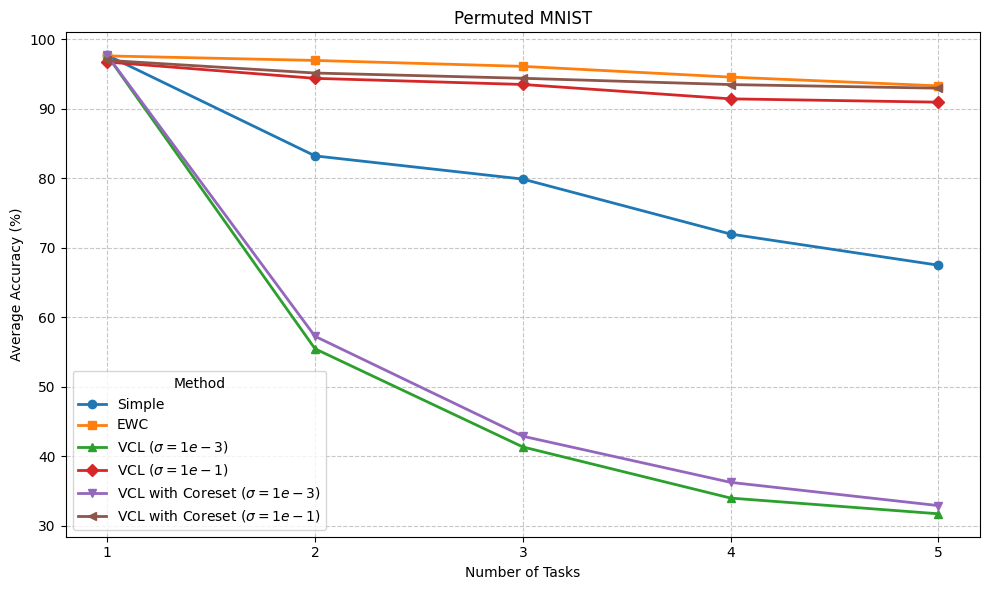

In [304]:
results = {
    "Simple": simple_results,
    "EWC": ewc_results,
    "VCL ($\\sigma=1e-3$)": vcl_base_results,
    "VCL ($\\sigma=1e-1$)": vcl_best_results,
    "VCL with Coreset ($\\sigma=1e-3$)": vcl_cs_base_results,
    "VCL with Coreset ($\\sigma=1e-1$)": vcl_cs_best_results
}

fig = plot_continual_learning_results(results, 
                                     title="Permuted MNIST",
                                     legend_title="Method")
# plt.show()

### Split

In [292]:
split_tasks = get_split_mnist(batch_size=256)
split_epochs = 5

print('Starting Simple')
simple_split_model, simple_split_results = train_simple_splitmnist(split_tasks, epochs=split_epochs, lr=1e-3)

print('-----------------------------------')
print('Starting EWC')
ewc_split_model, ewc_split_results = run_ewc_split_mnist(split_tasks, epochs=split_epochs, lambda_=5000)

print('-----------------------------------')
print('Starting VCL (base)')
vcl_split_base_model, vcl_split_base_results = run_vcl_split_mnist(split_tasks, init_std=1e-3, epochs=split_epochs)

print('-----------------------------------')
print('Starting VCL (optimized)')
vcl_split_opt_model, vcl_split_opt_results = run_vcl_split_mnist(split_tasks, init_std=1e-2, epochs=split_epochs)

print('-----------------------------------')
print('Starting VCL with Coreset (base)')
vcl_cs_split_base_model, vcl_cs_split_base_results = run_vcl_split_mnist_with_coreset(
    split_tasks,
    init_std=1e-3,
    epochs=split_epochs,
    coreset_size=200
)

print('-----------------------------------')
print('Starting VCL with Coreset (optimized)')
vcl_cs_split_opt_model, vcl_cs_split_opt_results = run_vcl_split_mnist_with_coreset(
    split_tasks,
    init_std=1e-1,
    epochs=split_epochs,
    coreset_size=200
)

split_results = {
    "Simple": simple_split_results,
    "EWC": ewc_split_results,
    "VCL ($\\sigma=1e-3$)": vcl_split_base_results,
    "VCL ($\\sigma=1e-2$)": vcl_split_opt_results,
    "VCL with Coreset ($\\sigma=1e-3$)": vcl_cs_split_base_results,
    "VCL with Coreset ($\\sigma=1e-1$)": vcl_cs_split_opt_results
}

Starting Simple

Training on split MNIST task 0...
Task 0 - Mean Acc so far: 99.95

Training on split MNIST task 1...
Task 1 - Mean Acc so far: 81.21

Training on split MNIST task 2...
Task 2 - Mean Acc so far: 63.62

Training on split MNIST task 3...
Task 3 - Mean Acc so far: 76.96

Training on split MNIST task 4...
Task 4 - Mean Acc so far: 56.46
-----------------------------------
Starting EWC
Training on Split MNIST Task 0 with EWC...
Task 0 - Accuracies: [99.95271867612293]
Task 0 - Mean Acc so far: 99.95
Training on Split MNIST Task 1 with EWC...
Task 1 - Accuracies: [75.31914893617021, 98.43290891283056]
Task 1 - Mean Acc so far: 86.88
Training on Split MNIST Task 2 with EWC...
Task 2 - Accuracies: [25.62647754137116, 76.83643486777669, 99.62646744930629]
Task 2 - Mean Acc so far: 67.36
Training on Split MNIST Task 3 with EWC...
Task 3 - Accuracies: [69.12529550827423, 90.00979431929481, 86.17929562433298, 99.04330312185297]
Task 3 - Mean Acc so far: 86.09
Training on Split MNIS

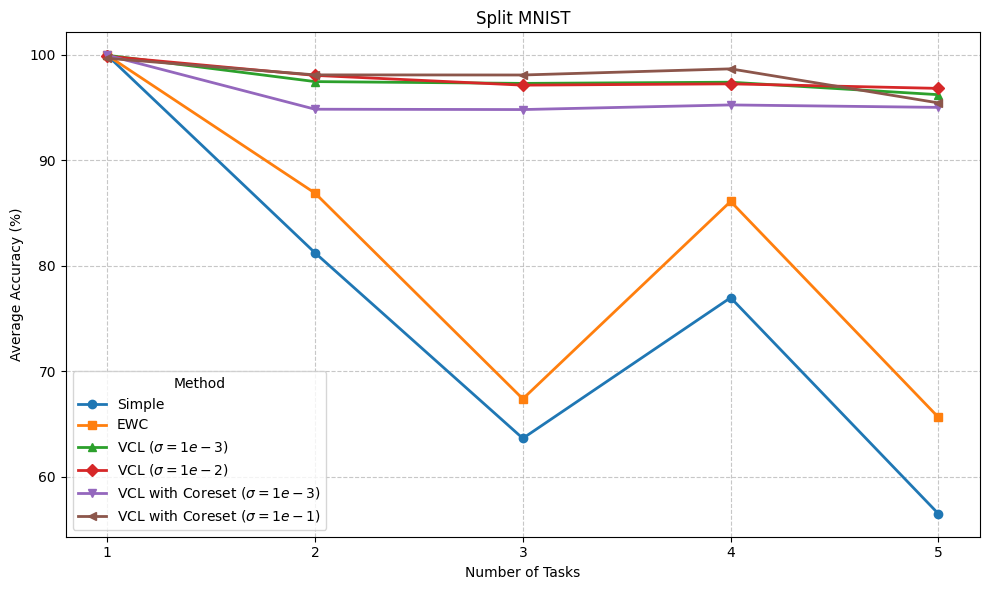

In [296]:
_ = plot_continual_learning_results(
    split_results, 
    title="Split MNIST",
    legend_title="Method"
)

### Gaussian Likelihood

In [358]:
def train_simple_regression(tasks, epochs=5, lr=1e-3):
    model = SimpleMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    results = []
    
    for task_ind, (train_loader, test_loader) in enumerate(tasks):
        print(f"\nTraining on regression task {task_ind}...")
        for ep in range(epochs):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                outputs = model(x)
                loss = F.mse_loss(outputs, y)
                loss.backward()
                optimizer.step()
        
        task_rmses = []
        for eval_ind, (_, eval_test_loader) in enumerate(tasks[:task_ind+1]):
            total_mse = 0.0
            total_samples = 0
            model.eval()
            with torch.no_grad():
                for x, y in eval_test_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    total_mse += F.mse_loss(outputs, y, reduction='sum').item()
                    total_samples += y.size(0) * y.size(1)
            rmse = np.sqrt(total_mse / total_samples)
            task_rmses.append(rmse)
        mean_rmse = np.mean(task_rmses)
        results.append((task_ind, mean_rmse))
        print(f"Task {task_ind} - Mean RMSE so far: {mean_rmse:.4f}")
    
    return model, results

def run_ewc_regression_tasks(tasks, epochs=3, lambda_=5000):
    model = SimpleMLP().to(device)
    ewc = EWC(model, fisher_sample_size=600, lambda_=lambda_)
    
    results = []
    
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        print(f"Training on Regression Task {t_idx} with EWC...")
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
        for epoch in range(epochs):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                
                outputs = model(x)
                task_loss = F.mse_loss(outputs, y)
                ewc_reg_loss = ewc.ewc_loss()
                loss = task_loss + ewc_reg_loss
                
                loss.backward()
                optimizer.step()
                
        ewc.consolidate_task(t_idx, train_loader)
        
        task_rmses = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            total_mse = 0.0
            total_samples = 0
            model.eval()
            with torch.no_grad():
                for x, y in test_loader_eval:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    total_mse += F.mse_loss(outputs, y, reduction='sum').item()
                    total_samples += y.size(0) * y.size(1)
            rmse = np.sqrt(total_mse / total_samples)
            task_rmses.append(rmse)
        
        mean_rmse = np.mean(task_rmses)
        results.append((t_idx, mean_rmse))
        print(f"Task {t_idx} - RMSEs: {task_rmses}")
        print(f"Task {t_idx} - Mean RMSE so far: {mean_rmse:.4f}")
    
    return model, results

def run_vcl_regression_with_coreset(tasks, epochs=3, init_std=1e-2, samples=1, coreset_size=200):
    model = VCL_NN(output_dim=10, init_std=init_std).to(device)
    
    coreset_x = []
    coreset_y = []
    
    results = []
    for t_idx, (train_loader, test_loader) in enumerate(tasks):
        if len(coreset_x) > 0:
            c_dataset = torch.utils.data.TensorDataset(
                torch.cat(coreset_x, dim=0),
                torch.cat(coreset_y, dim=0)
            )
            coreset_loader = DataLoader(c_dataset, batch_size=256, shuffle=True)
        else:
            coreset_loader = None
        
        print(f"Training on Regression Task {t_idx} with VCL+Coreset...")
        for ep in range(epochs):
            optimizer = optim.Adam(model.parameters(), lr=1e-3)
            model.train()
            
            task_size = len(train_loader.dataset)
            total_size = task_size
            if coreset_loader:
                total_size += len(coreset_loader.dataset)
            
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                
                loss = 0.0
                for _ in range(samples):
                    sampled_params = model.sample_params()
                    outputs = model(x, sampled_params)
                    loss += F.mse_loss(outputs, y)
                
                kl = model.prior_kl()
                loss = loss + kl / total_size
                
                loss.backward()
                optimizer.step()
            
            if coreset_loader:
                for x_c, y_c in coreset_loader:
                    x_c, y_c = x_c.to(device), y_c.to(device)
                    optimizer.zero_grad()
                    
                    loss = 0.0
                    for _ in range(samples):
                        sampled_params = model.sample_params()
                        outputs = model(x_c, sampled_params)
                        loss += F.mse_loss(outputs, y_c)
                    
                    kl = model.prior_kl()
                    loss = loss + kl / total_size
                    
                    loss.backward()
                    optimizer.step()
        
        model.consolidate_posteriors()
        
        task_rmses = []
        for eval_idx in range(t_idx+1):
            _, test_loader_eval = tasks[eval_idx]
            rmse = evaluate_vcl_regression(model, test_loader_eval, samples=5)
            task_rmses.append(rmse)
        
        mean_rmse = np.mean(task_rmses)
        results.append((t_idx, mean_rmse))
        print(f"Task {t_idx} - RMSEs: {task_rmses}")
        print(f"Task {t_idx} - Mean RMSE so far: {mean_rmse:.4f}")
        
        cx, cy = sample_coreset(train_loader, coreset_size=coreset_size)
        coreset_x.append(cx)
        coreset_y.append(cy)
    
    return model, results

In [321]:
regression_tasks = get_permuted_mnist_regression(n_tasks=5, batch_size=256)
regression_epochs = 10

print('Starting Simple Regression')
simple_reg_model, simple_reg_results = train_simple_regression(regression_tasks, epochs=regression_epochs)

print('-----------------------------------')
print('Running EWC Regression')
ewc_reg_model, ewc_reg_results = run_ewc_regression_tasks(regression_tasks, epochs=regression_epochs, lambda_=1)

Starting Simple Regression

Training on regression task 0...
Task 0 - Mean RMSE so far: 0.0667

Training on regression task 1...
Task 1 - Mean RMSE so far: 0.1221

Training on regression task 2...
Task 2 - Mean RMSE so far: 0.1577

Training on regression task 3...
Task 3 - Mean RMSE so far: 0.1837

Training on regression task 4...
Task 4 - Mean RMSE so far: 0.2228
-----------------------------------
Running EWC Regression
Training on Regression Task 0 with EWC...
Task 0 - RMSEs: [np.float64(0.0683395757252904)]
Task 0 - Mean RMSE so far: 0.0683
Training on Regression Task 1 with EWC...
Task 1 - RMSEs: [np.float64(0.08729587096344776), np.float64(0.07484684051691101)]
Task 1 - Mean RMSE so far: 0.0811
Training on Regression Task 2 with EWC...
Task 2 - RMSEs: [np.float64(0.1136630762476815), np.float64(0.09532182560621699), np.float64(0.08088916250906993)]
Task 2 - Mean RMSE so far: 0.0966
Training on Regression Task 3 with EWC...
Task 3 - RMSEs: [np.float64(0.13998999097075787), np.floa

In [ ]:
print('Running VCL Regression (base)')
vcl_reg_base_model, vcl_reg_base_results = run_vcl_permuted_mnist_regression(regression_tasks, init_std=1e-3, epochs=regression_epochs)

print('-----------------------------------')
print('Running VCL Regression (optimized)')
vcl_reg_opt_model, vcl_reg_opt_results = run_vcl_permuted_mnist_regression(regression_tasks, init_std=0.05, epochs=regression_epochs)

print('-----------------------------------')
print('Running VCL with Coreset Regression (base)')
vcl_cs_reg_base_model, vcl_cs_reg_base_results = run_vcl_regression_with_coreset(
    regression_tasks, 
    epochs=regression_epochs,
    init_std=1e-3,
    coreset_size=200
)

print('-----------------------------------')
print('Running VCL with Coreset Regression (optimized)')
vcl_cs_reg_opt_model, vcl_cs_reg_opt_results = run_vcl_regression_with_coreset(
    regression_tasks, 
    epochs=regression_epochs,
    init_std=0.05,
    coreset_size=200
)

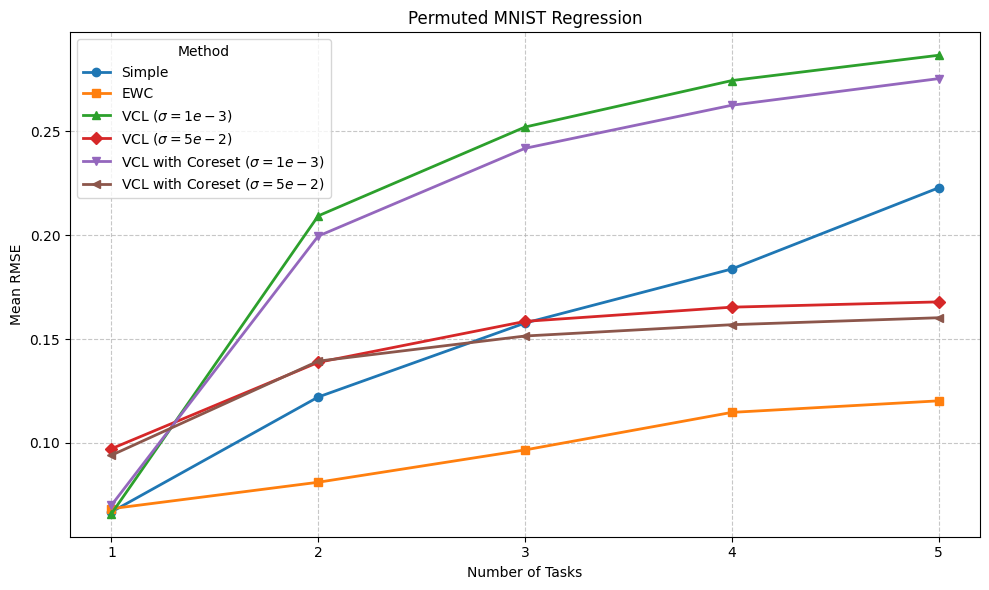

In [ ]:
regression_results = {
    "Simple": simple_reg_results,
    "EWC": ewc_reg_results,
    "VCL ($\\sigma=1e-3$)": [(i, rmse) for i, rmse in enumerate(vcl_reg_base_results)],
    "VCL ($\\sigma=5e-1$)": [(i, rmse) for i, rmse in enumerate(vcl_reg_opt_results)],
    "VCL with Coreset ($\\sigma=1e-3$)": vcl_cs_reg_base_results,
    "VCL with Coreset ($\\sigma=5e-1$)": vcl_cs_reg_opt_results,
}

plot_continual_learning_results(
    regression_results, 
    title="Permuted MNIST Regression",
    y_label="Mean RMSE",
    legend_title="Method"
)

plt.savefig('plots/reg_pmnist_all.png', dpi=300, bbox_inches='tight')
plt.show()

# Std Dev Sensitivity + KL Contribution

## VCL

In [ ]:
def train_vcl_with_kl_tracking(model, train_loader, samples=1, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    
    kl_values = []
    nll_values = []
    loss_values = []
    
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        nll_loss = 0.0
        for _ in range(samples):
            sampled_params = model.sample_params()
            logits = model(x, sampled_params)
            nll_loss += loss_fn(logits, y)
        nll_loss = nll_loss / samples
        
        kl = model.prior_kl()
        kl_normalized = kl / len(train_loader.dataset)
        
        loss = nll_loss + kl_normalized
        
        if torch.is_tensor(kl_normalized):
            kl_values.append(float(kl_normalized.detach().cpu().item()))
        else:
            kl_values.append(float(kl_normalized))
        nll_values.append(nll_loss.detach().cpu().item())
        loss_values.append(loss.detach().cpu().item())
        
        loss.backward()
        optimizer.step()
    
    return kl_values, nll_values, loss_values

def run_vcl_with_kl_tracking(init_stds, n_tasks=2, epochs=5):
    tasks = get_permuted_mnist(n_tasks=n_tasks, batch_size=256)
    
    results = {}
    
    for init_std in init_stds:
        print(f"Running with init_std={init_std}")
        model = VCL_NN(init_std=init_std).to(device)
        
        all_kl_values = []
        all_nll_values = []
        all_loss_values = []
        task_boundaries = []
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"  Training on Task {t_idx}")
            
            task_boundaries.append(len(all_kl_values))
            
            task_kl_values = []
            task_nll_values = []
            task_loss_values = []
            
            for ep in range(epochs):
                print(f"Epoch {ep+1}/{epochs}")
                kl_vals, nll_vals, loss_values = train_vcl_with_kl_tracking(
                    model, train_loader, samples=1, lr=1e-3
                )
                task_kl_values.extend(kl_vals)
                task_nll_values.extend(nll_vals)
                task_loss_values.extend(loss_values)
            
            all_kl_values.extend(task_kl_values)
            all_nll_values.extend(task_nll_values)
            all_loss_values.extend(task_loss_values)
            
            model.consolidate_posteriors()
        
        results[init_std] = {
            'kl_values': all_kl_values,
            'nll_values': all_nll_values,
            'loss_values': all_loss_values,
            'task_boundaries': task_boundaries
        }
    
    return results

def plot_loss_contribution(kl_tracking_results, loss_select='loss_values', figsize=(12, 8)):
    plt.figure(figsize=figsize)
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    # markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    plt.grid(True, linestyle='--', alpha=0.7)
    
    for i, (init_std, data) in enumerate(kl_tracking_results.items()):
        kl_values = data[loss_select]
        iterations = list(range(1, len(kl_values) + 1))
        
        # stride = max(1, len(kl_values) // 100)
        stride = 1
        sparse_iterations = iterations[::stride]
        sparse_kl_values = kl_values[::stride]
        
        plt.plot(
            sparse_iterations, 
            sparse_kl_values,
            label=f'init_std={init_std}',
            color=colors[i % len(colors)],
            # marker=markers[i % len(markers)],
            markersize=4,
            markevery=max(1, len(sparse_iterations) // 20)
        )

    first_key = list(kl_tracking_results.keys())[0]
    task_boundaries = kl_tracking_results[first_key].get('task_boundaries', [])
    
    for t_idx, boundary in enumerate(task_boundaries):
        if t_idx > 0:
            boundary_iter = boundary + 1
            
            plt.axvline(
                x=boundary_iter,
                color='gray', 
                linestyle='--', 
                alpha=0.7,
                linewidth=1.5
            )
            plt.text(
                boundary_iter, 
                0.95,
                f'Task {t_idx+1}', 
                color='black',
                ha='center', 
                va='top',
                fontsize=9,
                transform=plt.gca().get_xaxis_transform(),
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2')
            )
    
    plt.xlabel('Training Iterations')
    
    if loss_select == 'kl_values':
        plt.ylabel('KL Divergence Term')
        plt.title('KL Term Contribution During VCL Training')
    elif loss_select == 'nll_values':
        plt.ylabel('Negative Log-Likelihood')
        plt.title('NLL Term Contribution During VCL Training')
    else:
        plt.ylabel('Total Loss')
        plt.title('Total Loss During VCL Training')
        
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    return plt.gcf()

def analyze_kl_contribution(kl_results):
    plot_loss_contribution(kl_results, loss_select='kl_values')
    plt.savefig('plots/kl_contribution_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    plot_loss_contribution(kl_results, loss_select='nll_values')
    plt.savefig('plots/nll_contribution_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    plot_loss_contribution(kl_results, loss_select='loss_values')
    plt.savefig('plots/loss_contribution_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def evaluate_init_std_impact(init_stds, tasks, epochs=3, samples=5):
    accuracies = {}
    
    for init_std in init_stds:
        print(f"\nEvaluating init_std = {init_std}")
        model = VCL_NN(init_std=init_std).to(device)
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"  Training on Task {t_idx}")
            for ep in range(epochs):
                train_vcl_classification(model, train_loader, samples=1, lr=1e-3)
            model.consolidate_posteriors()
        
        task_accuracies = []
        for eval_idx, (_, test_loader) in enumerate(tasks):
            acc = evaluate_vcl_classification(model, test_loader, samples=samples)
            task_accuracies.append(acc)
            print(f"  Task {eval_idx} Accuracy: {acc:.2f}%")
        
        mean_acc = np.mean(task_accuracies)
        accuracies[init_std] = mean_acc
        print(f"  Mean Accuracy: {mean_acc:.2f}%")
    
    return accuracies

def plot_init_std_vs_accuracy(accuracies, figsize=(10, 6), save_path=None):
    plt.figure(figsize=figsize)
    
    init_stds = sorted(accuracies.keys())
    acc_values = [accuracies[std] for std in init_stds]
    
    plt.semilogx(init_stds, acc_values, 'o-', linewidth=2, markersize=8, color='blue')
    
    plt.xlabel('Initialization Standard Deviation (log scale)')
    plt.ylabel('Final Mean Accuracy (%)')
    plt.title('Impact of Initialization Standard Deviation on VCL Performance')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    for std, acc in zip(init_stds, acc_values):
        plt.text(std, acc + 1, f'{acc:.2f}%', ha='center', va='bottom')
    
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, max(y_max, max(acc_values) + 5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

def run_init_std_experiment(tasks, epochs=3):
    accuracies = evaluate_init_std_impact(init_stds, tasks, epochs=epochs)
    fig = plot_init_std_vs_accuracy(accuracies, save_path='plots/class_init_std_impact.png')
    plt.show()
    
    return accuracies, fig

### Split

In [ ]:
def evaluate_init_std_impact_splitmnist(init_stds, tasks, epochs=3, samples=5):
    accuracies = {}
    
    for init_std in init_stds:
        print(f"\nEvaluating init_std = {init_std}")
        model = VCL_NN(hidden_dim=256, output_dim=2, num_heads=len(tasks), init_std=init_std).to(device)
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"  Training on Task {t_idx}")
            for ep in range(epochs):
                train_vcl_classification_splitmnist(model, train_loader, head_idx=t_idx, samples=1, lr=1e-3)
            model.consolidate_posteriors(head_idx=t_idx)
        
        task_accuracies = []
        for eval_idx, (_, test_loader) in enumerate(tasks):
            acc = evaluate_vcl_classification_splitmnist(model, test_loader, head_idx=eval_idx, samples=samples)
            task_accuracies.append(acc)
            print(f"  Task {eval_idx} Accuracy: {acc:.2f}%")
        
        mean_acc = np.mean(task_accuracies)
        accuracies[init_std] = mean_acc
        print(f"  Mean Accuracy: {mean_acc:.2f}%")
    
    return accuracies

def run_init_std_experiment_splitmnist(init_stds, split_tasks, epochs=3):
    accuracies = evaluate_init_std_impact_splitmnist(
        init_stds,
        split_tasks, 
        epochs=epochs
    )
    
    fig = plot_init_std_vs_accuracy(
        accuracies, 
        save_path='plots/init_std_impact_splitmnist.png'
    )
    plt.show()
    
    return accuracies, fig

## VCL with Coreset

In [349]:
def train_vcl_with_kl_tracking_coreset(model, task_loader, coreset_loader=None, samples=1, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    
    kl_values = []
    nll_values = []
    loss_values = []
    
    task_size = len(task_loader.dataset)
    total_size = task_size
    if coreset_loader:
        total_size += len(coreset_loader.dataset)
    
    for batch_idx, (x, y) in enumerate(task_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        nll_loss = 0.0
        for _ in range(samples):
            sampled_params = model.sample_params()
            logits = model(x, sampled_params)
            nll_loss += loss_fn(logits, y)
        nll_loss = nll_loss / samples
        
        kl = model.prior_kl()
        kl_normalized = kl / total_size
        
        loss = nll_loss + kl_normalized
        
        if torch.is_tensor(kl_normalized):
            kl_values.append(float(kl_normalized.detach().cpu().item()))
        else:
            kl_values.append(float(kl_normalized))
        nll_values.append(nll_loss.detach().cpu().item())
        loss_values.append(loss.detach().cpu().item())
        
        loss.backward()
        optimizer.step()
    
    if coreset_loader:
        for batch_idx, (x_c, y_c) in enumerate(coreset_loader):
            x_c, y_c = x_c.to(device), y_c.to(device)
            optimizer.zero_grad()
            
            nll_loss = 0.0
            for _ in range(samples):
                sampled_params = model.sample_params()
                logits = model(x_c, sampled_params)
                nll_loss += loss_fn(logits, y_c)
            nll_loss = nll_loss / samples
            
            kl = model.prior_kl()
            kl_normalized = kl / total_size
            
            loss = nll_loss + kl_normalized
            
            if torch.is_tensor(kl_normalized):
                kl_values.append(float(kl_normalized.detach().cpu().item()))
            else:
                kl_values.append(float(kl_normalized))
            nll_values.append(nll_loss.detach().cpu().item())
            loss_values.append(loss.detach().cpu().item())
            
            loss.backward()
            optimizer.step()
    
    return kl_values, nll_values, loss_values

def run_vcl_with_kl_tracking_coreset(init_stds, n_tasks=2, epochs=5, coreset_size=200):
    tasks = get_permuted_mnist(n_tasks=n_tasks, batch_size=256)
    results = {}
    
    for init_std in init_stds:
        print(f"Running with init_std={init_std}")
        model = VCL_NN(init_std=init_std).to(device)
        
        coreset_x = []
        coreset_y = []
        
        all_kl_values = []
        all_nll_values = []
        all_loss_values = []
        task_boundaries = [] 
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"Training on Task {t_idx}")
            
            task_boundaries.append(len(all_kl_values))
            
            if len(coreset_x) > 0:
                c_dataset = torch.utils.data.TensorDataset(
                    torch.cat(coreset_x, dim=0),
                    torch.cat(coreset_y, dim=0)
                )
                coreset_loader = DataLoader(c_dataset, batch_size=64, shuffle=True)
            else:
                coreset_loader = None
            
            task_kl_values = []
            task_nll_values = []
            task_loss_values = []
            
            for ep in range(epochs):
                print(f"    Epoch {ep+1}/{epochs}")
                kl_vals, nll_vals, loss_vals = train_vcl_with_kl_tracking_coreset(
                    model, 
                    train_loader, 
                    coreset_loader=coreset_loader, 
                    samples=1, 
                    lr=1e-3
                )
                task_kl_values.extend(kl_vals)
                task_nll_values.extend(nll_vals)
                task_loss_values.extend(loss_vals)
            
            all_kl_values.extend(task_kl_values)
            all_nll_values.extend(task_nll_values)
            all_loss_values.extend(task_loss_values)
            
            model.consolidate_posteriors()
            
            cx, cy = sample_coreset(train_loader, coreset_size=coreset_size)
            coreset_x.append(cx)
            coreset_y.append(cy)
        
        results[init_std] = {
            'kl_values': all_kl_values,
            'nll_values': all_nll_values,
            'loss_values': all_loss_values,
            'task_boundaries': task_boundaries
        }
    
    return results

def analyze_kl_contribution_coreset(kl_results):
    plot_loss_contribution(kl_results, loss_select='kl_values')
    plt.savefig('plots/kl_contribution_coreset_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    plot_loss_contribution(kl_results, loss_select='nll_values')
    plt.savefig('plots/nll_contribution_coreset_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    plot_loss_contribution(kl_results, loss_select='loss_values')
    plt.savefig('plots/loss_contribution_coreset_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def evaluate_init_std_impact_coreset(init_stds, tasks, epochs=3, samples=5, coreset_size=200):
    accuracies = {}
    
    for init_std in init_stds:
        print(f"\nEvaluating init_std = {init_std} with coreset")
        model = VCL_NN(init_std=init_std).to(device)
        
        coreset_x = []
        coreset_y = []
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"Training on Task {t_idx}")
            
            if len(coreset_x) > 0:
                c_dataset = torch.utils.data.TensorDataset(
                    torch.cat(coreset_x, dim=0),
                    torch.cat(coreset_y, dim=0)
                )
                coreset_loader = DataLoader(c_dataset, batch_size=256, shuffle=True)
            else:
                coreset_loader = None
            
            for ep in range(epochs):
                train_vcl_classification_with_coreset(
                    model,
                    train_loader,
                    coreset_loader=coreset_loader,
                    samples=1,
                    lr=1e-3
                )
            
            model.consolidate_posteriors()
            
            cx, cy = sample_coreset(train_loader, coreset_size=coreset_size)
            coreset_x.append(cx)
            coreset_y.append(cy)
        
        task_accuracies = []
        for eval_idx, (_, test_loader) in enumerate(tasks):
            acc = evaluate_vcl_classification(model, test_loader, samples=samples)
            task_accuracies.append(acc)
            print(f"Task {eval_idx} Accuracy: {acc:.2f}%")
        
        mean_acc = np.mean(task_accuracies)
        accuracies[init_std] = mean_acc
        print(f"Mean Accuracy: {mean_acc:.2f}%")
    
    return accuracies

def run_init_std_experiment_coreset(epochs=3, coreset_size=200):
    init_stds = [0.001, 0.01, 0.05, 0.1, 0.5]
    tasks = get_permuted_mnist(n_tasks=5, batch_size=256)
    
    accuracies = evaluate_init_std_impact_coreset(
        init_stds, 
        tasks, 
        epochs=epochs, 
        coreset_size=coreset_size
    )
    
    fig = plot_init_std_vs_accuracy(
        accuracies, 
        save_path=f'plots/init_std_impact_coreset_{coreset_size}.png'
    )
    plt.show()
    
    return accuracies, fig

### Split

In [351]:
def evaluate_init_std_impact_splitmnist_coreset(init_stds, tasks, epochs=3, samples=10, coreset_size=200):
    accuracies = {}
    
    for init_std in init_stds:
        print(f"\nEvaluating init_std = {init_std} on Split MNIST with coreset")
        model = VCL_NN(hidden_dim=256, output_dim=2, num_heads=len(tasks), init_std=init_std).to(device)
        
        coreset_x = []
        coreset_y = []
        coreset_task_ids = []
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"  Training on Task {t_idx}")
            
            if len(coreset_x) > 0:
                c_dataset = torch.utils.data.TensorDataset(
                    torch.cat(coreset_x, dim=0),
                    torch.cat(coreset_y, dim=0),
                    torch.cat(coreset_task_ids, dim=0)
                )
                coreset_loader = DataLoader(c_dataset, batch_size=256, shuffle=True)
            else:
                coreset_loader = None
            
            for ep in range(epochs):
                train_vcl_classification_splitmnist_with_coreset(
                    model,
                    train_loader,
                    head_idx=t_idx,
                    coreset_loader=coreset_loader,
                    samples=1,
                    lr=1e-3
                )
            
            model.consolidate_posteriors(head_idx=t_idx)
            
            cx, cy = sample_coreset(train_loader, coreset_size=coreset_size)
            task_ids = torch.full((cy.size(0),), t_idx, dtype=torch.long)
            cy = cy % 2 
            
            coreset_x.append(cx)
            coreset_y.append(cy)
            coreset_task_ids.append(task_ids)
        
        task_accuracies = []
        for eval_idx, (_, test_loader) in enumerate(tasks):
            acc = evaluate_vcl_classification_splitmnist(model, test_loader, head_idx=eval_idx, samples=samples)
            task_accuracies.append(acc)
            print(f"Task {eval_idx} Accuracy: {acc:.2f}%")
        
        mean_acc = np.mean(task_accuracies)
        accuracies[init_std] = mean_acc
        print(f"Mean Accuracy: {mean_acc:.2f}%")
    
    return accuracies

def run_init_std_experiment_splitmnist_coreset(init_stds, split_tasks, epochs=3, coreset_size=200):
    accuracies = evaluate_init_std_impact_splitmnist_coreset(
        init_stds, 
        split_tasks, 
        epochs=epochs,
        coreset_size=coreset_size
    )
    
    fig = plot_init_std_vs_accuracy(
        accuracies, 
        save_path=f'plots/init_std_impact_splitmnist_coreset_{coreset_size}.png'
    )
    plt.show()
    
    return accuracies, fig

## Gaussian Regression VCL

In [ ]:
def train_vcl_regression_with_kl_tracking(model, train_loader, samples=1, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    kl_values = []
    mse_values = []
    loss_values = []
    
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        mse_loss = 0.0
        for _ in range(samples):
            sampled_params = model.sample_params()
            outputs = model(x, sampled_params)
            mse_loss += F.mse_loss(outputs, y)
        mse_loss = mse_loss / samples
        
        kl = model.prior_kl()
        kl /= len(train_loader.dataset)
        
        loss = mse_loss + kl
        
        if torch.is_tensor(kl):
            kl_values.append(float(kl.detach().cpu().item()))
        else:
            kl_values.append(float(kl))
        mse_values.append(mse_loss.detach().cpu().item())
        loss_values.append(loss.detach().cpu().item())
        
        loss.backward()
        optimizer.step()
    
    return kl_values, mse_values, loss_values

def run_vcl_regression_with_kl_tracking(init_stds, n_tasks=2, epochs=3):
    tasks = get_permuted_mnist_regression(n_tasks=n_tasks, batch_size=256)
    results = {}
    
    for init_std in init_stds:
        print(f"Running regression with init_std={init_std}")
        model = VCL_NN(output_dim=10).to(device)
        
        all_kl_values = []
        all_mse_values = []
        all_loss_values = []
        task_boundaries = []
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"  Training on Regression Task {t_idx}")            
            task_boundaries.append(len(all_kl_values))
            
            task_kl_values = []
            task_mse_values = []
            task_loss_values = []
            
            for ep in range(epochs):
                print(f"    Epoch {ep+1}/{epochs}")
                kl_vals, mse_vals, loss_vals = train_vcl_regression_with_kl_tracking(
                    model, train_loader, samples=1, lr=1e-3
                )
                task_kl_values.extend(kl_vals)
                task_mse_values.extend(mse_vals)
                task_loss_values.extend(loss_vals)
            
            all_kl_values.extend(task_kl_values)
            all_mse_values.extend(task_mse_values)
            all_loss_values.extend(task_loss_values)
            
            model.consolidate_posteriors()
        
        results[init_std] = {
            'kl_values': all_kl_values,
            'nll_values': all_mse_values,
            'loss_values': all_loss_values,
            'task_boundaries': task_boundaries
        }
    
    return results

def analyze_kl_contribution_regression(kl_results):
    plot_loss_contribution(kl_results, loss_select='kl_values')
    plt.savefig('plots/kl_contribution_regression_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    plot_loss_contribution(kl_results, loss_select='nll_values')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Term Contribution During VCL Regression')
    plt.savefig('plots/mse_contribution_regression_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    plot_loss_contribution(kl_results, loss_select='loss_values')
    plt.savefig('plots/loss_contribution_regression_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return kl_results

def evaluate_init_std_impact_regression(init_stds, tasks, epochs=3, samples=5):
    rmse_results = {}
    
    for init_std in init_stds:
        print(f"\nEvaluating regression with init_std = {init_std}")
        model = VCL_NN(output_dim=10).to(device)
        
        for t_idx, (train_loader, _) in enumerate(tasks):
            print(f"Training on Task {t_idx}")
            for ep in range(epochs):
                train_vcl_regression(model, train_loader, samples=1, lr=1e-3)
            model.consolidate_posteriors()
        
        task_rmses = []
        for eval_idx, (_, test_loader) in enumerate(tasks):
            rmse = evaluate_vcl_regression(model, test_loader, samples=samples)
            task_rmses.append(rmse)
            print(f"Task {eval_idx} RMSE: {rmse:.4f}")
        
        mean_rmse = np.mean(task_rmses)
        rmse_results[init_std] = mean_rmse
        print(f"Mean RMSE: {mean_rmse:.4f}")
    
    return rmse_results

def plot_init_std_vs_rmse(rmse_results, figsize=(10, 6), save_path=None):
    plt.figure(figsize=figsize)
    
    init_stds = sorted(rmse_results.keys())
    rmse_values = [rmse_results[std] for std in init_stds]
    
    plt.semilogx(init_stds, rmse_values, 'o-', linewidth=2, markersize=8, color='blue')
    
    plt.xlabel('Initialization Standard Deviation (log scale)')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('Impact of Initialization Standard Deviation on VCL Regression')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim([0.2, 0.3])

    for std, rmse in zip(init_stds, rmse_values):
        plt.text(std, rmse + 0.001, f'{rmse:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

## Plot VCL

In [168]:
init_stds = [0.001, 0.01, 0.05, 0.1, 0.5]#, 0.1]
n_tasks = 5
epochs = 3

kl_results = run_vcl_with_kl_tracking(init_stds, n_tasks=n_tasks, epochs=epochs)

Running with init_std=0.001
  Training on Task 0
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 1
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 2
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 3
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 4
Epoch 1/3
Epoch 2/3
Epoch 3/3
Running with init_std=0.01
  Training on Task 0
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 1
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 2
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 3
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 4
Epoch 1/3
Epoch 2/3
Epoch 3/3
Running with init_std=0.05
  Training on Task 0
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 1
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 2
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 3
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 4
Epoch 1/3
Epoch 2/3
Epoch 3/3
Running with init_std=0.1
  Training on Task 0
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 1
Epoch 1/3
Epoch 2/3
Epoch 3/3
  Training on Task 2
Epoc

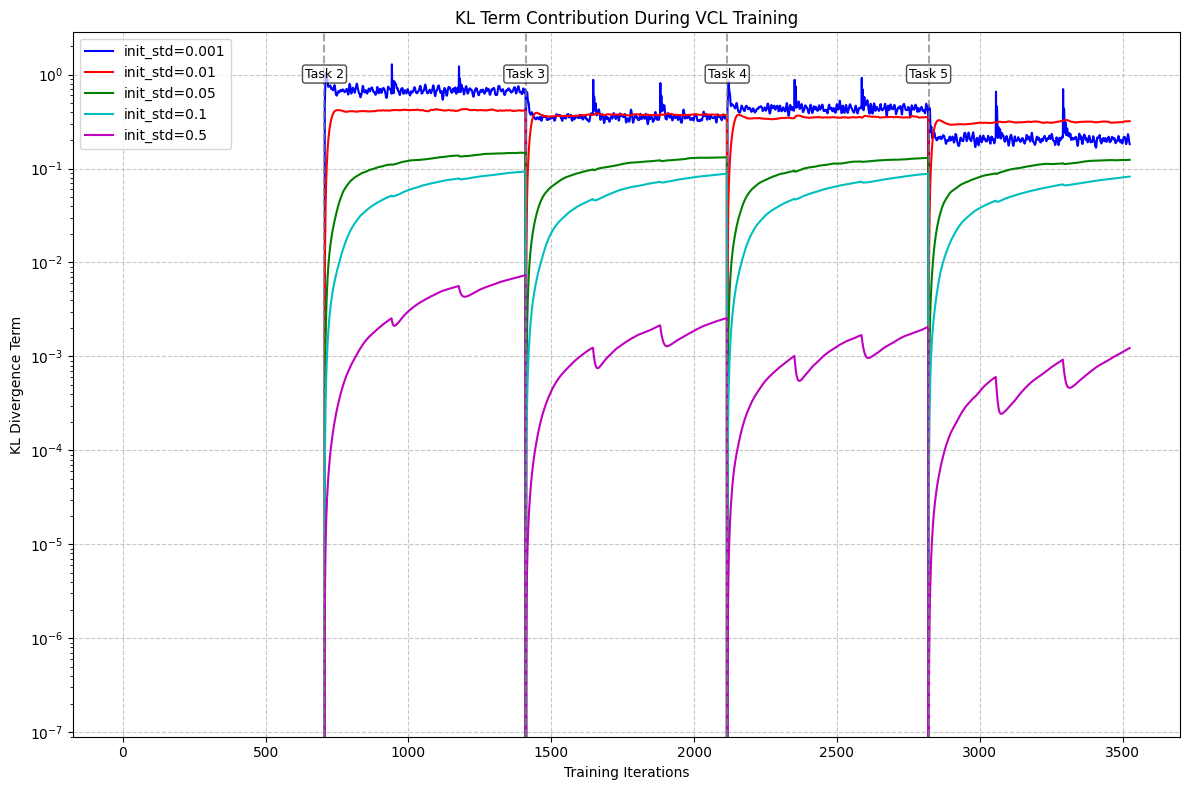

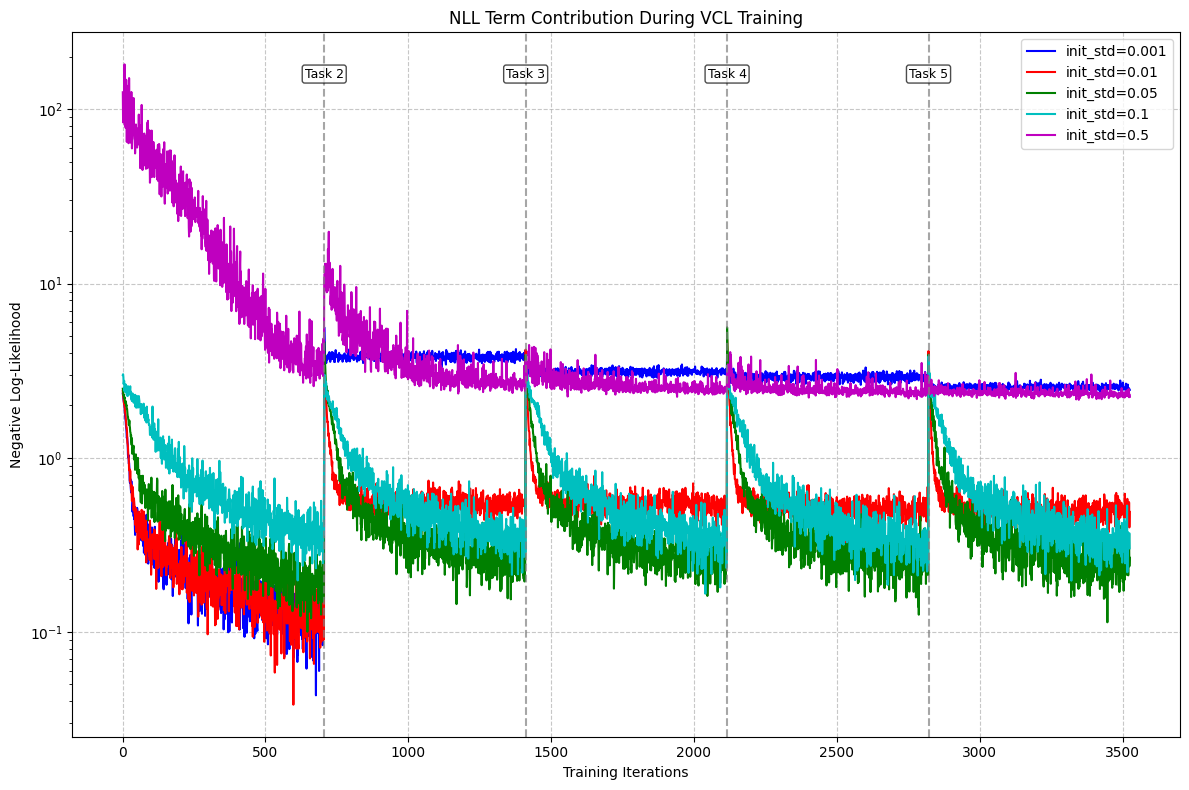

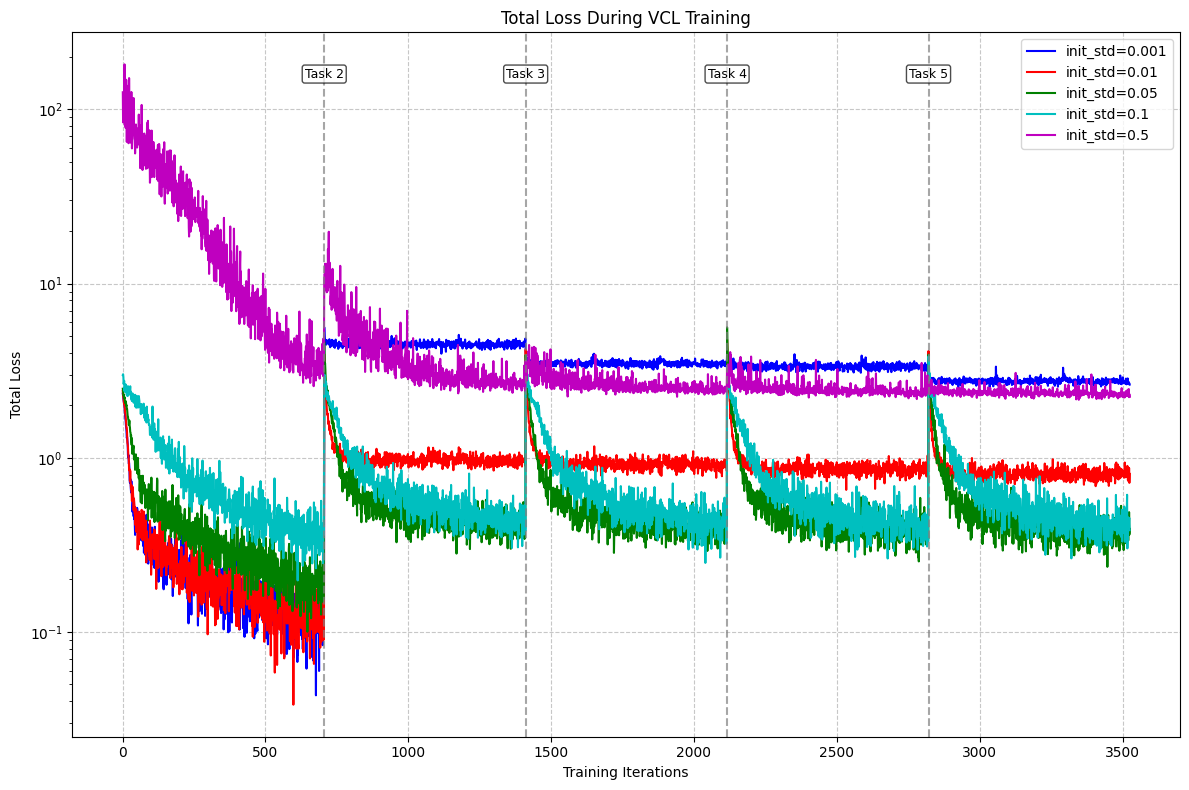

In [362]:
_ = analyze_kl_contribution(kl_results)

#### Permuted

In [ ]:
init_stds = [0.001, 0.01, 0.05, 0.1, 0.5]
vcl_tasks = get_permuted_mnist(n_tasks=5, batch_size=256)
run_init_std_experiment(vcl_tasks, epochs=10)

#### Split


Evaluating init_std = 0.001
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 Accuracy: 99.95%
  Task 1 Accuracy: 93.83%
  Task 2 Accuracy: 92.53%
  Task 3 Accuracy: 97.89%
  Task 4 Accuracy: 93.90%
  Mean Accuracy: 95.62%

Evaluating init_std = 0.01
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 Accuracy: 99.95%
  Task 1 Accuracy: 95.15%
  Task 2 Accuracy: 97.01%
  Task 3 Accuracy: 98.29%
  Task 4 Accuracy: 95.92%
  Mean Accuracy: 97.26%

Evaluating init_std = 0.05
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 Accuracy: 98.11%
  Task 1 Accuracy: 77.96%
  Task 2 Accuracy: 98.45%
  Task 3 Accuracy: 98.04%
  Task 4 Accuracy: 97.43%
  Mean Accuracy: 94.00%

Evaluating init_std = 0.1
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task

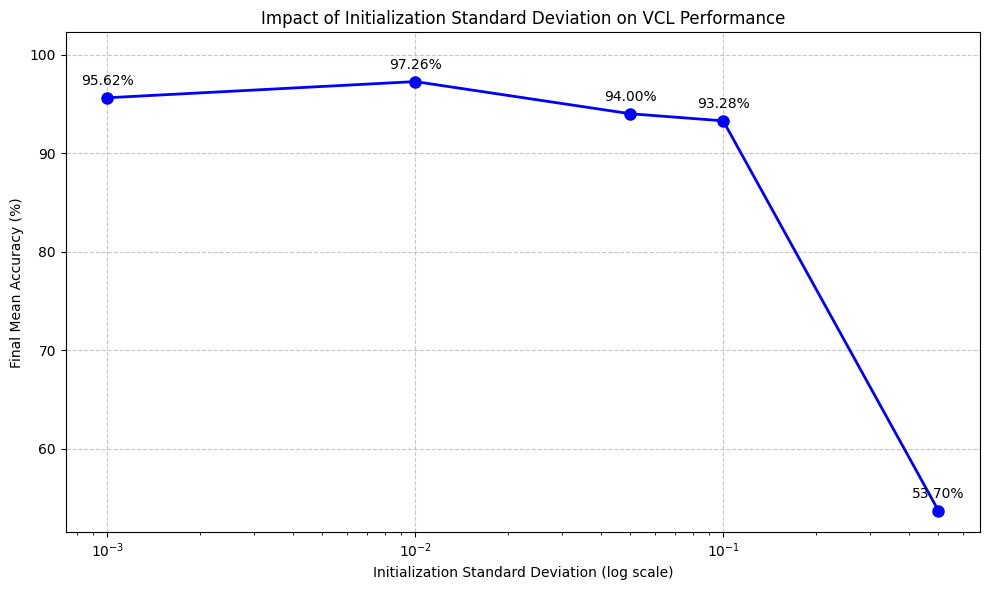

({0.001: np.float64(95.61899540426664),
  0.01: np.float64(97.26391324228072),
  0.05: np.float64(93.99768591907139),
  0.1: np.float64(93.27904408966387),
  0.5: np.float64(53.69707357086919)},
 <Figure size 1000x600 with 1 Axes>)

In [250]:
init_stds = [0.001, 0.01, 0.05, 0.1, 0.5]
split_tasks = get_split_mnist(batch_size=256)
run_init_std_experiment_splitmnist(init_stds, split_tasks, epochs=5)

## Plot VCL with Coreset

In [187]:
init_stds = [0.001, 0.01, 0.05, 0.1, 0.5]#, 0.1]
n_tasks = 5
epochs = 3

kl_coreset_results = run_vcl_with_kl_tracking_coreset(
        init_stds, 
        n_tasks=n_tasks, 
        epochs=epochs, 
        coreset_size=200
    )

Running with init_std=0.001
  Training on Task 0
    No coreset available yet
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 1
    Using coreset with 200 examples
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 2
    Using coreset with 400 examples
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 3
    Using coreset with 600 examples
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 4
    Using coreset with 800 examples
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
Running with init_std=0.01
  Training on Task 0
    No coreset available yet
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 1
    Using coreset with 200 examples
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 2
    Using coreset with 400 examples
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 3
    Using coreset with 600 examples
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Task 4
    Using coreset with 800 examples
    Epoch 1

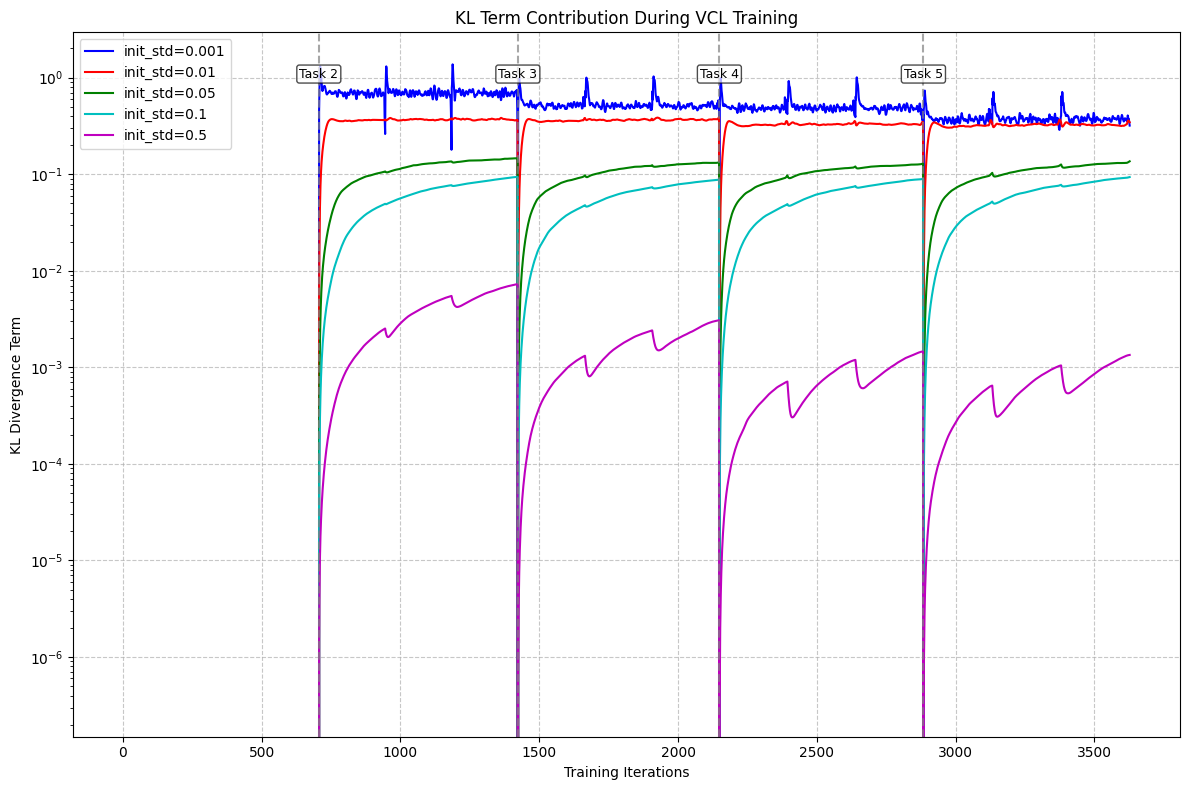

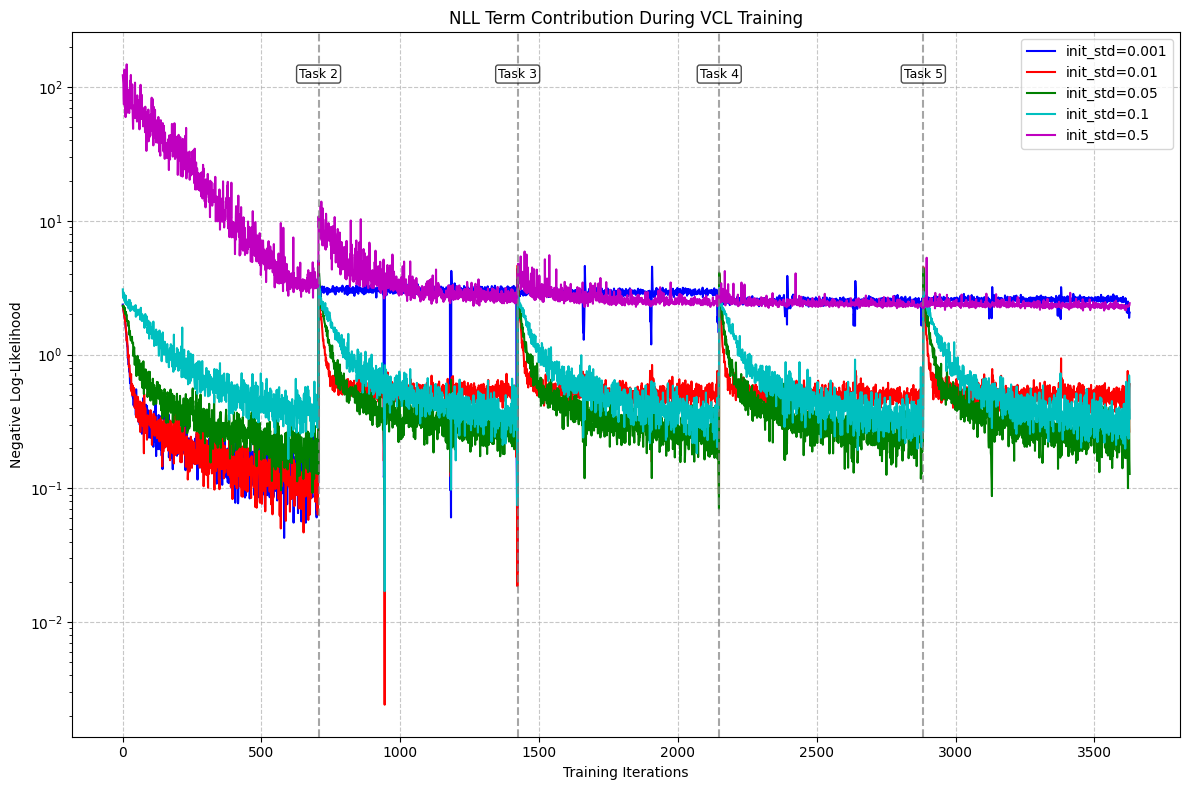

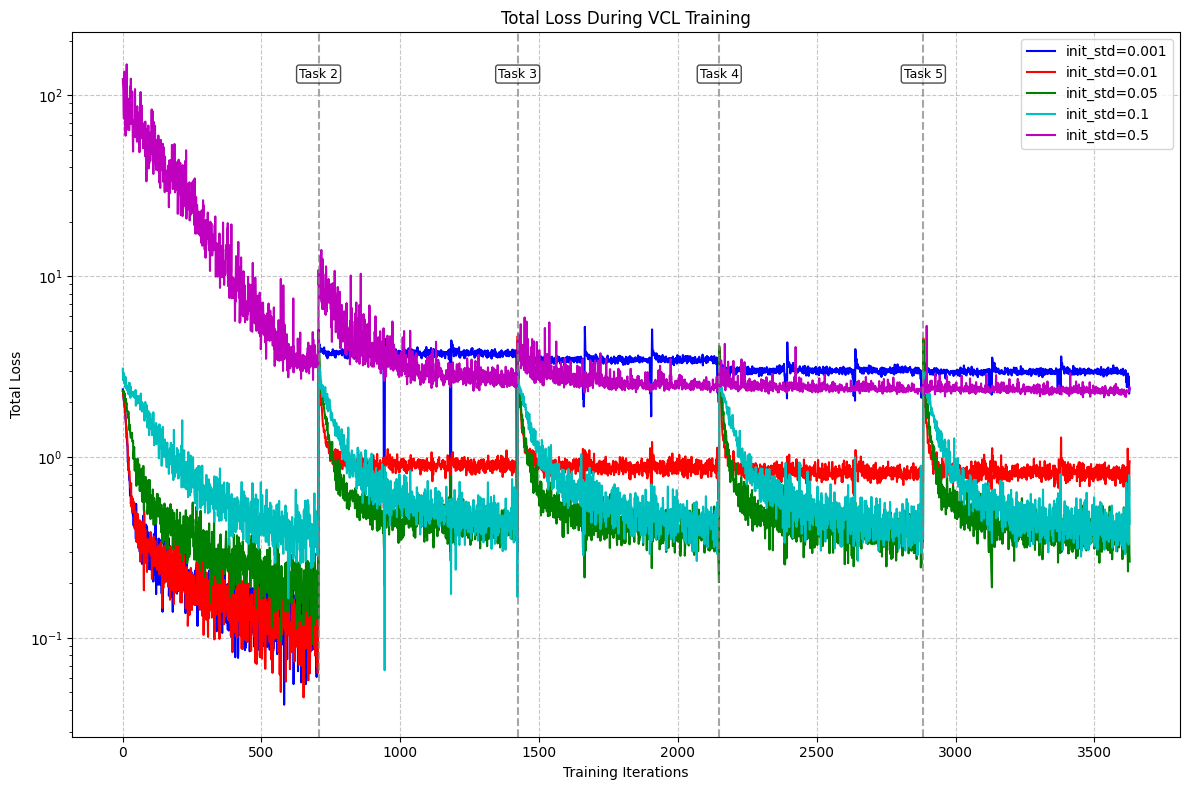

In [363]:
_ = analyze_kl_contribution_coreset(kl_coreset_results)

### Permuted


Evaluating init_std = 0.001 with coreset
Training on Task 0
Training on Task 1
Training on Task 2
Training on Task 3
Training on Task 4
Task 0 Accuracy: 96.04%
Task 1 Accuracy: 24.03%
Task 2 Accuracy: 23.79%
Task 3 Accuracy: 16.31%
Task 4 Accuracy: 5.85%
Mean Accuracy: 33.20%

Evaluating init_std = 0.01 with coreset
Training on Task 0
Training on Task 1
Training on Task 2
Training on Task 3
Training on Task 4
Task 0 Accuracy: 92.68%
Task 1 Accuracy: 79.68%
Task 2 Accuracy: 79.74%
Task 3 Accuracy: 83.70%
Task 4 Accuracy: 81.08%
Mean Accuracy: 83.38%

Evaluating init_std = 0.05 with coreset
Training on Task 0
Training on Task 1
Training on Task 2
Training on Task 3
Training on Task 4
Task 0 Accuracy: 93.35%
Task 1 Accuracy: 89.79%
Task 2 Accuracy: 91.41%
Task 3 Accuracy: 92.90%
Task 4 Accuracy: 95.41%
Mean Accuracy: 92.57%

Evaluating init_std = 0.1 with coreset
Training on Task 0
Training on Task 1
Training on Task 2
Training on Task 3
Training on Task 4
Task 0 Accuracy: 92.46%
Task 1 

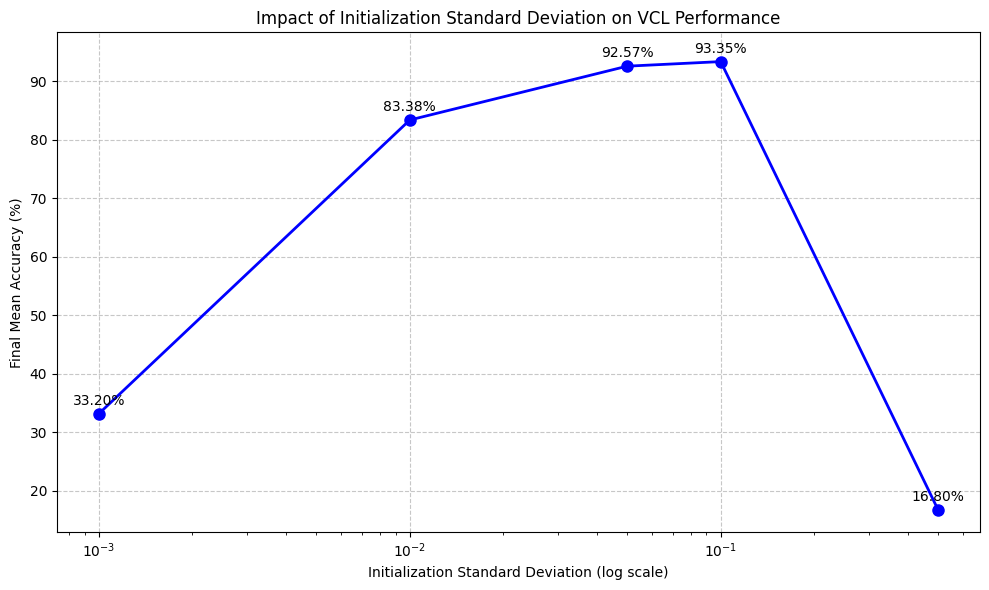

({0.001: np.float64(33.204),
  0.01: np.float64(83.376),
  0.05: np.float64(92.57199999999997),
  0.1: np.float64(93.354),
  0.5: np.float64(16.798)},
 <Figure size 1000x600 with 1 Axes>)

In [300]:
run_init_std_experiment_coreset(epochs=10)

### Split

In [ ]:
init_stds = [0.001, 0.01, 0.05, 0.1, 0.5]
split_tasks = get_split_mnist(batch_size=256)


Evaluating init_std = 0.001 on Split MNIST with coreset
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 Accuracy: 99.91%
  Task 1 Accuracy: 83.89%
  Task 2 Accuracy: 92.21%
  Task 3 Accuracy: 97.03%
  Task 4 Accuracy: 91.33%
  Mean Accuracy: 92.87%

Evaluating init_std = 0.01 on Split MNIST with coreset
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 Accuracy: 99.95%
  Task 1 Accuracy: 94.17%
  Task 2 Accuracy: 80.63%
  Task 3 Accuracy: 91.19%
  Task 4 Accuracy: 68.18%
  Mean Accuracy: 86.82%

Evaluating init_std = 0.05 on Split MNIST with coreset
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 Accuracy: 99.91%
  Task 1 Accuracy: 97.11%
  Task 2 Accuracy: 98.88%
  Task 3 Accuracy: 89.93%
  Task 4 Accuracy: 68.63%
  Mean Accuracy: 90.89%

Evaluating init_std = 0.1 on Split MNIST with coreset

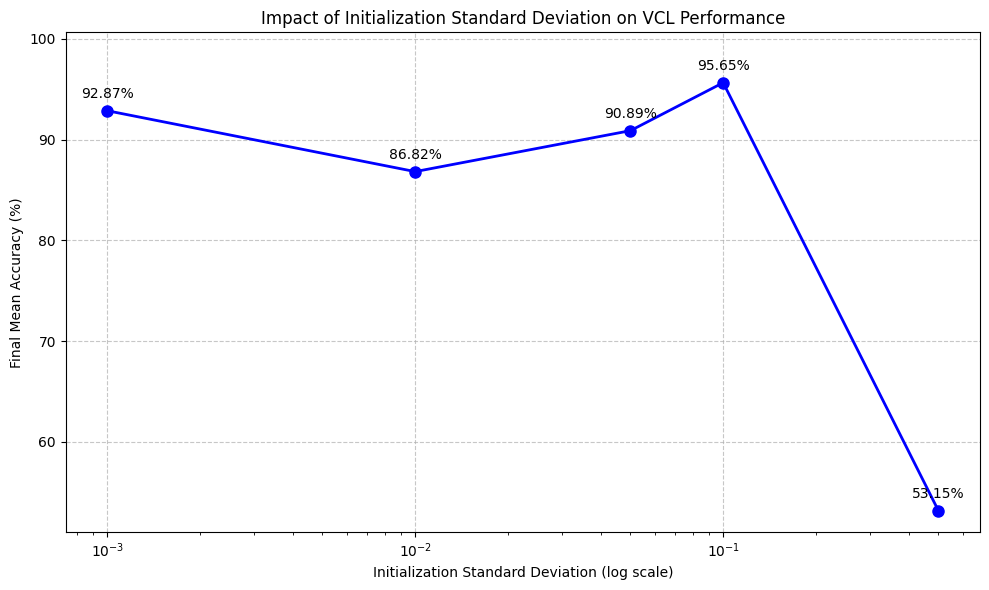

({0.001: np.float64(92.87168761898765),
  0.01: np.float64(86.82452241018797),
  0.05: np.float64(90.89168116319873),
  0.1: np.float64(95.65424811851736),
  0.5: np.float64(53.151260059849584)},
 <Figure size 1000x600 with 1 Axes>)

In [255]:
run_init_std_experiment_splitmnist_coreset(init_stds, split_tasks, epochs=5)

## Plot GRVCL

In [199]:
kl_regression_results = run_vcl_regression_with_kl_tracking(
    [0.001, 0.01, 0.05, 0.1, 0.5],
    n_tasks=5,
    epochs=3
)

Running regression with init_std=0.001
  Training on Regression Task 0
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 1
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 2
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 3
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 4
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
Running regression with init_std=0.01
  Training on Regression Task 0
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 1
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 2
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 3
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 4
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
Running regression with init_std=0.05
  Training on Regression Task 0
    Epoch 1/3
    Epoch 2/3
    Epoch 3/3
  Training on Regression Task 1
    Epoch 1/3
    Epoch 2/3
    Epoch 3

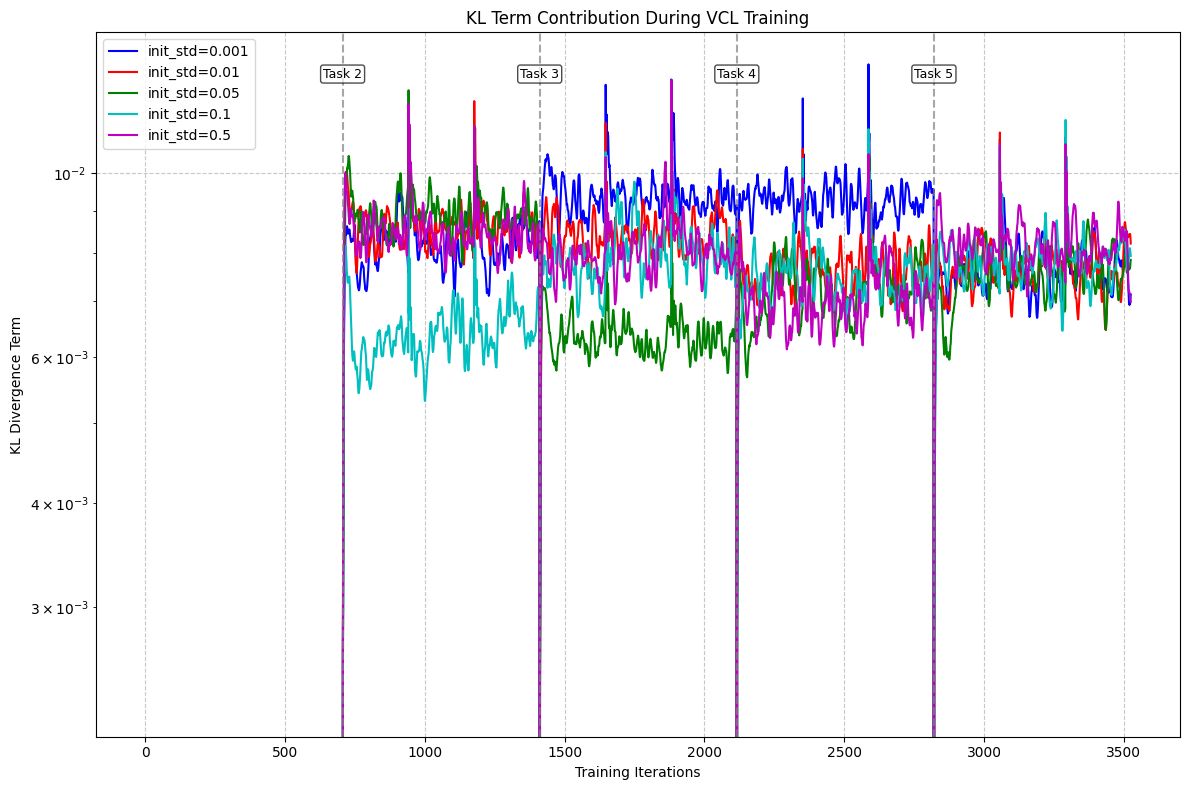

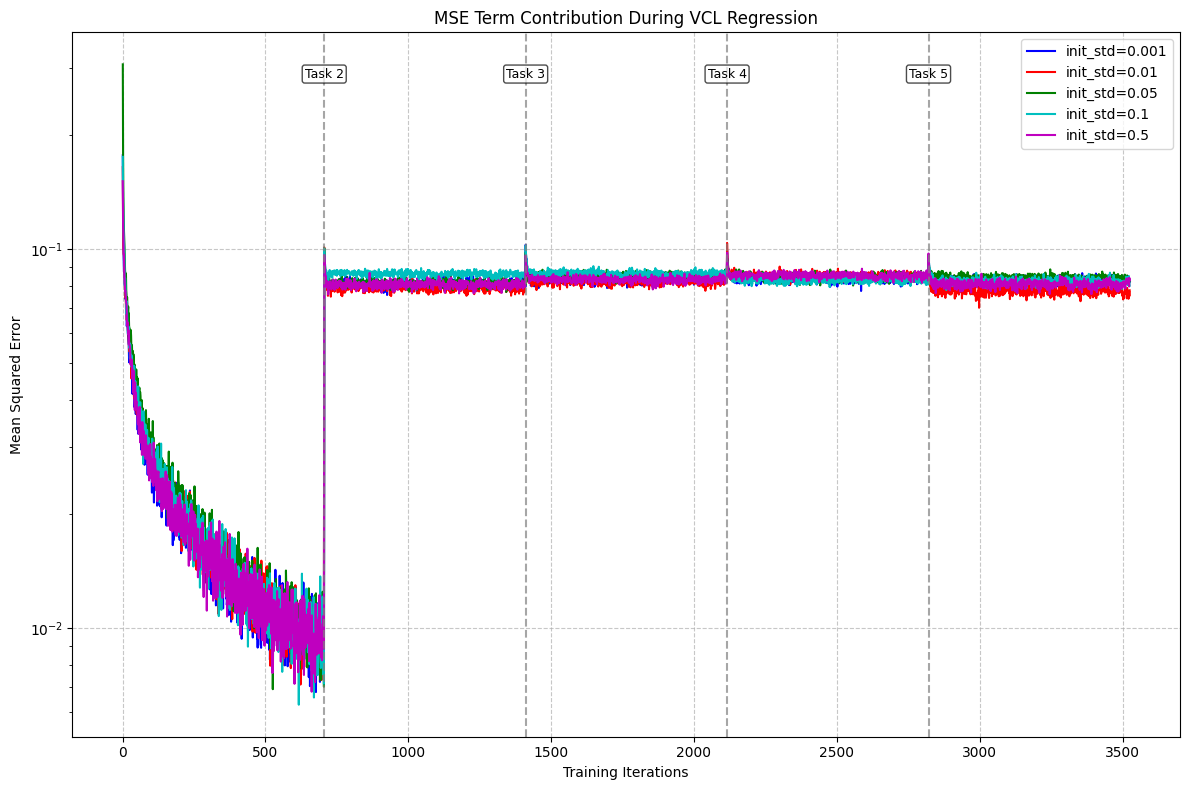

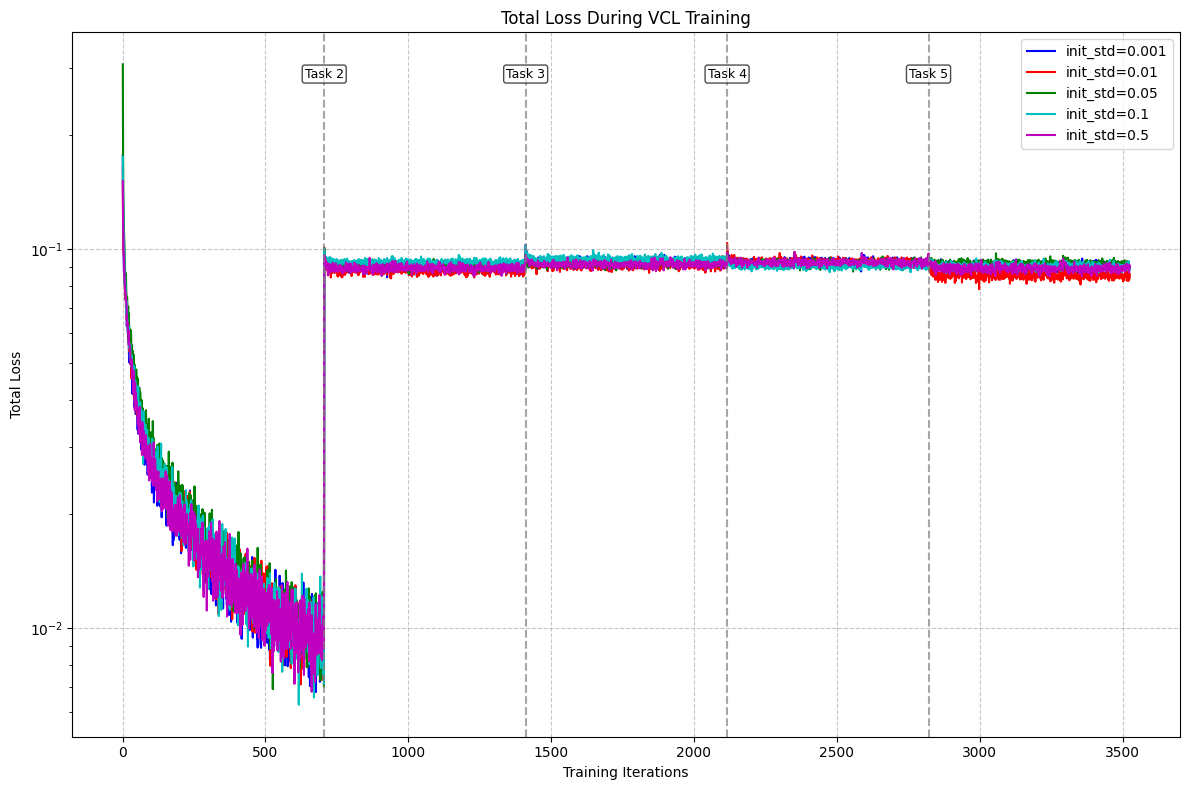

In [364]:
_ = analyze_kl_contribution_regression(kl_regression_results)

In [226]:
init_stds = [0.001, 0.01, 0.05, 0.1, 0.5]
tasks = get_permuted_mnist_regression(n_tasks=5, batch_size=256)
rmse_results = evaluate_init_std_impact_regression(init_stds, tasks, epochs=10)


Evaluating regression with init_std = 0.001
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 RMSE: 0.1033
  Task 1 RMSE: 0.2977
  Task 2 RMSE: 0.2946
  Task 3 RMSE: 0.2917
  Task 4 RMSE: 0.2923
  Mean RMSE: 0.2559

Evaluating regression with init_std = 0.01
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 RMSE: 0.0963
  Task 1 RMSE: 0.2939
  Task 2 RMSE: 0.2882
  Task 3 RMSE: 0.2917
  Task 4 RMSE: 0.2917
  Mean RMSE: 0.2524

Evaluating regression with init_std = 0.05
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 RMSE: 0.1007
  Task 1 RMSE: 0.2959
  Task 2 RMSE: 0.2919
  Task 3 RMSE: 0.2970
  Task 4 RMSE: 0.2974
  Mean RMSE: 0.2566

Evaluating regression with init_std = 0.1
  Training on Task 0
  Training on Task 1
  Training on Task 2
  Training on Task 3
  Training on Task 4
  Task 0 RMSE:

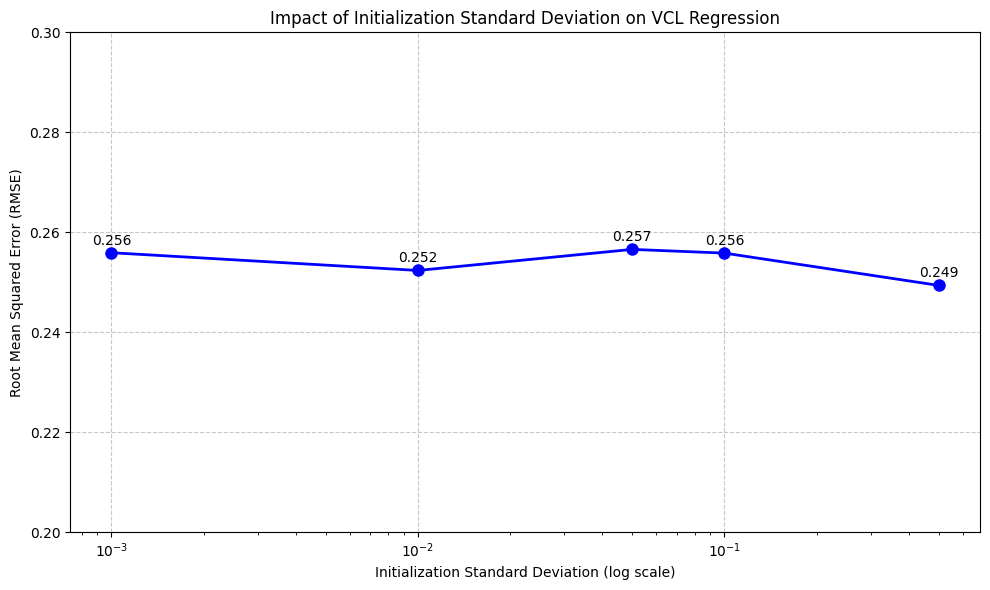

In [320]:
plot_init_std_vs_rmse(rmse_results, save_path='plots/reg_init_std_impact.png')